In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']
plt.rcParams['font.size'] = 12

In [2]:
import renyi
import utils
from renyi import renyi_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel
from renyi import test_mixture_divergence, renyi_mixture_divergence_stable
from renyi import renyi_mixture_divergence, renyi_sim_divergence, renyi_sim_divergence_stable

In [3]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [4]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [256, 256]
batch_size_p = 600
batch_size_q = 600

In [32]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [39]:
alpha = 1e-4
sigma_mult = 1

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs_p = torch.ones(1, batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(1, batch_size_q).cuda()/batch_size_q

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2 * sigma_mult], log=True))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

D = lambda x, y: renyi_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, alpha,
                                                 use_avg=False, use_full=False, symmetric=True)

# D = lambda x, y: test_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel,
#                                          symmetric=True, use_avg=False)

for g in g_optimizer.param_groups:
    g['lr'] = 1e-4

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

#         x = x_real[:batch_size//2]
#         x_prime = x_real[batch_size//2:]
#         y = x_fake[:batch_size//2]
#         y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.0167
200 - 0.0240
400 - 0.0179
600 - 0.0240
800 - 0.0125
1000 - 0.0246
1200 - 0.0139
1400 - 0.0148
1600 - 0.0231
1800 - 0.0145
2000 - 0.0171
2200 - 0.0167
2400 - 0.0161
2600 - 0.0133
2800 - 0.0145
3000 - 0.0174
3200 - 0.0240
3400 - 0.0195
3600 - 0.0132
3800 - 0.0107
4000 - 0.0172
4200 - 0.0131
4400 - 0.0123
4600 - 0.0147
4800 - 0.0111


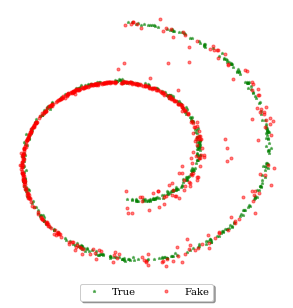

In [40]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.00), fancybox=True, shadow=True, ncol=2);

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

cur_axes.spines['top'].set_visible(False)
cur_axes.spines['right'].set_visible(False)
cur_axes.spines['bottom'].set_visible(False)
cur_axes.spines['left'].set_visible(False)

plt.savefig('swiss_roll.pdf', dpi=100)

In [354]:
bs1, bs2, n = 100, 80, 10
# bs1, bs2, n = 4, 2, 5

K = torch.rand(n, n).double()
for i in range(n):
    K[i,i] = 1.0
K = (K + K.t()) / 2
log_K = torch.log(K)

# K = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[2], log=False))
# log_K = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[2], log=True))

p = torch.rand(bs1, n).double()
p[:, 1] = 0
p = p / p.sum(dim=1, keepdim=True)
q = torch.rand(bs1, n).double()
q[:, 0] = 0
q = q / q.sum(dim=1, keepdim=True)

Y = torch.randn(bs1, n).double() * 2
X = torch.randn(bs2, n).double()

alpha, P1 = 1, False

In [355]:
renyi_sim_divergence(K, p, q, alpha, P1).abs().sum(), renyi_sim_divergence_stable(log_K, p, q, alpha, P1).abs().sum()

(tensor(13.8918, dtype=torch.float64), tensor(13.8918, dtype=torch.float64))

In [6]:
from sinkhorn_pointcloud import sinkhorn_normalized

In [13]:
epsilon = 0.02
niter = 10
D = lambda x, y: sinkhorn_normalized(x, y, epsilon, batch_size_p, niter)

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_p, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.8522
200 - 0.0915
400 - 0.0725
600 - 0.0474
800 - 0.0247
1000 - 0.0217
1200 - 0.0186
1400 - 0.0152
1600 - 0.0156
1800 - 0.0187


KeyboardInterrupt: 

In [35]:
import utils

class Model(nn.Module):

    def __init__(self, size=4, alpha=1, bs=1, n=2, d=1):
        super().__init__()
        self.alpha = alpha
        self.d = d
        self.size = size

        self.locs = nn.Parameter(torch.randn(size, n))
        self.p = nn.Parameter(torch.randn(bs, size // 2))
        self.q = nn.Parameter(torch.randn(bs, size))

    def forward(self):
        log_K = -utils.batch_pdist(self.locs, self.locs) ** self.d
        p = torch.cat([F.softmax(self.p, dim=1), torch.zeros_like(self.p)], dim=1)
        q = F.softmax(self.q, dim=1)

        log_pK = torch.logsumexp(log_K[None, ...] + torch.log(p[:, None, :]), dim=2)
        log_qK = torch.logsumexp(log_K[None, ...] + torch.log(q[:, None, :]), dim=2)

        rat1 = (log_pK, log_qK)
        rat2 = (log_qK, log_pK)

        alpha = self.alpha
        if np.abs(alpha - 1.0) < 1e-8:
            dp1 = (p * (rat1[0] - rat1[1])).sum(-1)
            dp2 = (q * (rat2[0] - rat2[1])).sum(-1)
            loss = 0.5 * (dp1 + dp2)
        else:
            power_pq = torch.log(p) + (alpha - 1) * (rat1[0] - rat1[1])
            power_qp = torch.log(q) + (alpha - 1) * (rat2[0] - rat2[1])
            loss = 0.5 * (1 / (alpha - 1)) * (torch.logsumexp(power_pq, -1) + torch.logsumexp(power_qp, -1))

        return loss, p, q, torch.exp(log_K)

In [36]:
losses = []

for alpha in [1e-3]: #[1e-3, 0.5, 1, 2]:
    for d in [2]:  #[1e-3, 1, 2]:
        print(alpha, d)
        model = Model(alpha=alpha, d=d, size=6).cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

        for _ in range(5000):
            optimizer.zero_grad()
            loss, p, q, K = model()
            if loss < -1e-6:
                print(loss.item())
                print(p, q)
                print(K)
                print('-----')
            loss.backward()
            optimizer.step()

        final_loss = loss.item()
        print(final_loss)
        losses.append(final_loss)
        print()

0.001 2
-9.299801604356617e-05
tensor([[0.0514, 0.0422, 0.9064, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0839, 0.0905, 0.1326, 0.2779, 0.0750, 0.3401]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.2231e-01, 1.4681e-05, 5.9821e-01, 1.2380e-01, 9.3640e-01],
        [2.2231e-01, 1.0000e+00, 7.5992e-05, 6.7951e-01, 8.1379e-01, 3.4181e-01],
        [1.4681e-05, 7.5992e-05, 1.0000e+00, 2.5125e-04, 4.5452e-06, 8.7535e-06],
        [5.9821e-01, 6.7951e-01, 2.5125e-04, 1.0000e+00, 3.7000e-01, 6.7381e-01],
        [1.2380e-01, 8.1379e-01, 4.5452e-06, 3.7000e-01, 1.0000e+00, 2.3180e-01],
        [9.3640e-01, 3.4181e-01, 8.7535e-06, 6.7381e-01, 2.3180e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.00025349127827212214
tensor([[0.0514, 0.0421, 0.9065, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0838, 0.0905, 0.1326, 0.2778, 0.0749, 0.3403]], device='cuda:0',
 

       grad_fn=<CatBackward>) tensor([[0.0836, 0.0901, 0.1320, 0.2769, 0.0729, 0.3445]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.2892e-01, 1.4374e-05, 6.0842e-01, 1.2808e-01, 9.3779e-01],
        [2.2892e-01, 1.0000e+00, 7.4844e-05, 6.8859e-01, 8.1721e-01, 3.5556e-01],
        [1.4374e-05, 7.4844e-05, 1.0000e+00, 2.2555e-04, 4.6624e-06, 9.4061e-06],
        [6.0842e-01, 6.8859e-01, 2.2555e-04, 1.0000e+00, 3.8237e-01, 6.9699e-01],
        [1.2808e-01, 8.1721e-01, 4.6624e-06, 3.8237e-01, 1.0000e+00, 2.3986e-01],
        [9.3779e-01, 3.5556e-01, 9.4061e-06, 6.9699e-01, 2.3986e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0030316293705254793
tensor([[0.0501, 0.0410, 0.9088, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0836, 0.0900, 0.1320, 0.2768, 0.0728, 0.3448]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.2927e-01, 1.4357e-05, 6.0897e-01, 1.2831e-01, 9.3785

-0.005617756396532059
tensor([[0.0488, 0.0400, 0.9112, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0832, 0.0895, 0.1314, 0.2758, 0.0708, 0.3494]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.3553e-01, 1.4047e-05, 6.1853e-01, 1.3251e-01, 9.3850e-01],
        [2.3553e-01, 1.0000e+00, 7.3482e-05, 6.9728e-01, 8.2094e-01, 3.6997e-01],
        [1.4047e-05, 7.3482e-05, 1.0000e+00, 2.0177e-04, 4.7794e-06, 1.0105e-05],
        [6.1853e-01, 6.9728e-01, 2.0177e-04, 1.0000e+00, 3.9507e-01, 7.2032e-01],
        [1.3251e-01, 8.2094e-01, 4.7794e-06, 3.9507e-01, 1.0000e+00, 2.4859e-01],
        [9.3850e-01, 3.6997e-01, 1.0105e-05, 7.2032e-01, 2.4859e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.00575630459934473
tensor([[0.0488, 0.0399, 0.9113, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0832, 0.0895, 0.1313, 0.2757, 0.0707, 0.3496]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 2.4114e-01, 1.3754e-05, 6.2704e-01, 1.3642e-01, 9.3853e-01],
        [2.4114e-01, 1.0000e+00, 7.2145e-05, 7.0434e-01, 8.2437e-01, 3.8278e-01],
        [1.3754e-05, 7.2145e-05, 1.0000e+00, 1.8301e-04, 4.8777e-06, 1.0733e-05],
        [6.2704e-01, 7.0434e-01, 1.8301e-04, 1.0000e+00, 4.0612e-01, 7.4017e-01],
        [1.3642e-01, 8.2437e-01, 4.8777e-06, 4.0612e-01, 1.0000e+00, 2.5660e-01],
        [9.3853e-01, 3.8278e-01, 1.0733e-05, 7.4017e-01, 2.5660e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.008030151948332787
tensor([[0.0475, 0.0389, 0.9136, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0828, 0.0889, 0.1307, 0.2747, 0.0689, 0.3540]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.4146e-01, 1.3736e-05, 6.2752e-01, 1.3664e-01, 9.3851e-01],
        [2.4146e-01, 1.0000e+00, 7.2064e-05, 7.0474e-01, 8.2457e-01, 3.8353e-01],
        [1.3736e-05, 7.2064e-05, 1.0000e+00, 1.8197e

       grad_fn=<CatBackward>) tensor([[0.0824, 0.0883, 0.1299, 0.2736, 0.0670, 0.3588]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.4709e-01, 1.3426e-05, 6.3599e-01, 1.4071e-01, 9.3792e-01],
        [2.4709e-01, 1.0000e+00, 7.0533e-05, 7.1150e-01, 8.2829e-01, 3.9698e-01],
        [1.3426e-05, 7.0533e-05, 1.0000e+00, 1.6447e-04, 4.9801e-06, 1.1433e-05],
        [6.3599e-01, 7.1150e-01, 1.6447e-04, 1.0000e+00, 4.1812e-01, 7.6121e-01],
        [1.4071e-01, 8.2829e-01, 4.9801e-06, 4.1812e-01, 1.0000e+00, 2.6575e-01],
        [9.3792e-01, 3.9698e-01, 1.1433e-05, 7.6121e-01, 2.6575e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.010405370034277439
tensor([[0.0461, 0.0377, 0.9162, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0824, 0.0882, 0.1298, 0.2736, 0.0669, 0.3591]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.4740e-01, 1.3409e-05, 6.3644e-01, 1.4094e-01, 9.3787e

       grad_fn=<CatBackward>) tensor([[0.0819, 0.0875, 0.1290, 0.2725, 0.0651, 0.3640]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.5274e-01, 1.3100e-05, 6.4439e-01, 1.4494e-01, 9.3670e-01],
        [2.5274e-01, 1.0000e+00, 6.8811e-05, 7.1793e-01, 8.3230e-01, 4.1104e-01],
        [1.3100e-05, 6.8811e-05, 1.0000e+00, 1.4814e-04, 5.0741e-06, 1.2124e-05],
        [6.4439e-01, 7.1793e-01, 1.4814e-04, 1.0000e+00, 4.2973e-01, 7.8103e-01],
        [1.4494e-01, 8.3230e-01, 5.0741e-06, 4.2973e-01, 1.0000e+00, 2.7512e-01],
        [9.3670e-01, 4.1104e-01, 1.2124e-05, 7.8103e-01, 2.7512e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.01262098178267479
tensor([[0.0446, 0.0365, 0.9188, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0819, 0.0875, 0.1289, 0.2724, 0.0650, 0.3642]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.5303e-01, 1.3083e-05, 6.4482e-01, 1.4516e-01, 9.3662e-

-0.014585376717150211
tensor([[0.0433, 0.0355, 0.9213, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0814, 0.0867, 0.1280, 0.2714, 0.0633, 0.3692]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.5809e-01, 1.2777e-05, 6.5229e-01, 1.4911e-01, 9.3492e-01],
        [2.5809e-01, 1.0000e+00, 6.6996e-05, 7.2371e-01, 8.3637e-01, 4.2494e-01],
        [1.2777e-05, 6.6996e-05, 1.0000e+00, 1.3373e-04, 5.1592e-06, 1.2798e-05],
        [6.5229e-01, 7.2371e-01, 1.3373e-04, 1.0000e+00, 4.4096e-01, 7.9965e-01],
        [1.4911e-01, 8.3637e-01, 5.1592e-06, 4.4096e-01, 1.0000e+00, 2.8471e-01],
        [9.3492e-01, 4.2494e-01, 1.2798e-05, 7.9965e-01, 2.8471e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.014690915122628212
tensor([[0.0432, 0.0354, 0.9214, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0813, 0.0867, 0.1280, 0.2713, 0.0632, 0.3695]], device='cuda:0',
       grad_

-0.01652919128537178
tensor([[0.0418, 0.0343, 0.9238, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0808, 0.0859, 0.1270, 0.2702, 0.0616, 0.3745]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.6318e-01, 1.2457e-05, 6.5971e-01, 1.5323e-01, 9.3264e-01],
        [2.6318e-01, 1.0000e+00, 6.5103e-05, 7.2889e-01, 8.4049e-01, 4.3868e-01],
        [1.2457e-05, 6.5103e-05, 1.0000e+00, 1.2098e-04, 5.2352e-06, 1.3449e-05],
        [6.5971e-01, 7.2889e-01, 1.2098e-04, 1.0000e+00, 4.5182e-01, 8.1708e-01],
        [1.5323e-01, 8.4049e-01, 5.2352e-06, 4.5182e-01, 1.0000e+00, 2.9450e-01],
        [9.3264e-01, 4.3868e-01, 1.3449e-05, 8.1708e-01, 2.9450e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.016628069803118706
tensor([[0.0417, 0.0343, 0.9240, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0808, 0.0858, 0.1270, 0.2701, 0.0615, 0.3748]], device='cuda:0',
       grad_f

tensor([[0.0404, 0.0333, 0.9264, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0802, 0.0850, 0.1259, 0.2690, 0.0599, 0.3800]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.6802e-01, 1.2140e-05, 6.6670e-01, 1.5729e-01, 9.2991e-01],
        [2.6802e-01, 1.0000e+00, 6.3150e-05, 7.3353e-01, 8.4466e-01, 4.5224e-01],
        [1.2140e-05, 6.3150e-05, 1.0000e+00, 1.0968e-04, 5.3017e-06, 1.4069e-05],
        [6.6670e-01, 7.3353e-01, 1.0968e-04, 1.0000e+00, 4.6230e-01, 8.3335e-01],
        [1.5729e-01, 8.4466e-01, 5.3017e-06, 4.6230e-01, 1.0000e+00, 3.0448e-01],
        [9.2991e-01, 4.5224e-01, 1.4069e-05, 8.3335e-01, 3.0448e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.018443096429109573
tensor([[0.0403, 0.0332, 0.9265, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0801, 0.0850, 0.1259, 0.2689, 0.0598, 0.3802]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


-0.020058991387486458
tensor([[0.0390, 0.0322, 0.9288, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0795, 0.0841, 0.1248, 0.2678, 0.0583, 0.3854]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.7263e-01, 1.1829e-05, 6.7327e-01, 1.6130e-01, 9.2678e-01],
        [2.7263e-01, 1.0000e+00, 6.1150e-05, 7.3768e-01, 8.4884e-01, 4.6560e-01],
        [1.1829e-05, 6.1150e-05, 1.0000e+00, 9.9638e-05, 5.3586e-06, 1.4651e-05],
        [6.7327e-01, 7.3768e-01, 9.9638e-05, 1.0000e+00, 4.7240e-01, 8.4849e-01],
        [1.6130e-01, 8.4884e-01, 5.3586e-06, 4.7240e-01, 1.0000e+00, 3.1466e-01],
        [9.2678e-01, 4.6560e-01, 1.4651e-05, 8.4849e-01, 3.1466e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.02014603465795517
tensor([[0.0389, 0.0321, 0.9289, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0795, 0.0841, 0.1248, 0.2677, 0.0582, 0.3857]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 2.7656e-01, 1.1553e-05, 6.7883e-01, 1.6486e-01, 9.2367e-01],
        [2.7656e-01, 1.0000e+00, 5.9333e-05, 7.4101e-01, 8.5260e-01, 4.7736e-01],
        [1.1553e-05, 5.9333e-05, 1.0000e+00, 9.1592e-05, 5.4013e-06, 1.5135e-05],
        [6.7883e-01, 7.4101e-01, 9.1592e-05, 1.0000e+00, 4.8114e-01, 8.6111e-01],
        [1.6486e-01, 8.5260e-01, 5.4013e-06, 4.8114e-01, 1.0000e+00, 3.2392e-01],
        [9.2367e-01, 4.7736e-01, 1.5135e-05, 8.6111e-01, 3.2392e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.021581733599305153
tensor([[0.0377, 0.0312, 0.9311, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0789, 0.0832, 0.1237, 0.2666, 0.0568, 0.3907]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.7678e-01, 1.1537e-05, 6.7914e-01, 1.6507e-01, 9.2348e-01],
        [2.7678e-01, 1.0000e+00, 5.9226e-05, 7.4120e-01, 8.5282e-01, 4.7805e-01],
        [1.1537e-05, 5.9226e-05, 1.0000e+00, 9.1144e

tensor([[0.0365, 0.0303, 0.9332, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0782, 0.0824, 0.1226, 0.2655, 0.0555, 0.3957]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.8053e-01, 1.1265e-05, 6.8439e-01, 1.6859e-01, 9.2012e-01],
        [2.8053e-01, 1.0000e+00, 5.7392e-05, 7.4418e-01, 8.5658e-01, 4.8962e-01],
        [1.1265e-05, 5.7392e-05, 1.0000e+00, 8.3924e-05, 5.4380e-06, 1.5605e-05],
        [6.8439e-01, 7.4418e-01, 8.3924e-05, 1.0000e+00, 4.9009e-01, 8.7356e-01],
        [1.6859e-01, 8.5658e-01, 5.4380e-06, 4.9009e-01, 1.0000e+00, 3.3387e-01],
        [9.2012e-01, 4.8962e-01, 1.5605e-05, 8.7356e-01, 3.3387e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.023018117994070053
tensor([[0.0365, 0.0303, 0.9333, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0782, 0.0823, 0.1226, 0.2655, 0.0554, 0.3960]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


-0.024227267131209373
tensor([[0.0354, 0.0295, 0.9352, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0775, 0.0815, 0.1215, 0.2644, 0.0542, 0.4008]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.8412e-01, 1.0996e-05, 6.8935e-01, 1.7208e-01, 9.1653e-01],
        [2.8412e-01, 1.0000e+00, 5.5551e-05, 7.4686e-01, 8.6033e-01, 5.0099e-01],
        [1.0996e-05, 5.5551e-05, 1.0000e+00, 7.7397e-05, 5.4646e-06, 1.6005e-05],
        [6.8935e-01, 7.4686e-01, 7.7397e-05, 1.0000e+00, 4.9825e-01, 8.8449e-01],
        [1.7208e-01, 8.6033e-01, 5.4646e-06, 4.9825e-01, 1.0000e+00, 3.4339e-01],
        [9.1653e-01, 5.0099e-01, 1.6005e-05, 8.8449e-01, 3.4339e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.024300826713442802
tensor([[0.0353, 0.0294, 0.9353, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0775, 0.0814, 0.1215, 0.2644, 0.0542, 0.4011]], device='cuda:0',
       grad_

-0.025376901030540466
tensor([[0.0343, 0.0287, 0.9370, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0769, 0.0807, 0.1205, 0.2633, 0.0531, 0.4055]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.8735e-01, 1.0746e-05, 6.9378e-01, 1.7534e-01, 9.1299e-01],
        [2.8735e-01, 1.0000e+00, 5.3820e-05, 7.4913e-01, 8.6385e-01, 5.1150e-01],
        [1.0746e-05, 5.3820e-05, 1.0000e+00, 7.1819e-05, 5.4827e-06, 1.6339e-05],
        [6.9378e-01, 7.4913e-01, 7.1819e-05, 1.0000e+00, 5.0570e-01, 8.9407e-01],
        [1.7534e-01, 8.6385e-01, 5.4827e-06, 5.0570e-01, 1.0000e+00, 3.5245e-01],
        [9.1299e-01, 5.1150e-01, 1.6339e-05, 8.9407e-01, 3.5245e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.02544688992202282
tensor([[0.0343, 0.0286, 0.9371, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0769, 0.0806, 0.1204, 0.2633, 0.0530, 0.4058]], device='cuda:0',
       grad_f

-0.02660398744046688
tensor([[0.0332, 0.0278, 0.9390, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0762, 0.0797, 0.1193, 0.2621, 0.0518, 0.4109]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.9082e-01, 1.0468e-05, 6.9850e-01, 1.7898e-01, 9.0883e-01],
        [2.9082e-01, 1.0000e+00, 5.1881e-05, 7.5142e-01, 8.6779e-01, 5.2309e-01],
        [1.0468e-05, 5.1881e-05, 1.0000e+00, 6.6129e-05, 5.4949e-06, 1.6664e-05],
        [6.9850e-01, 7.5142e-01, 6.6129e-05, 1.0000e+00, 5.1380e-01, 9.0406e-01],
        [1.7898e-01, 8.6779e-01, 5.4949e-06, 5.1380e-01, 1.0000e+00, 3.6276e-01],
        [9.0883e-01, 5.2309e-01, 1.6664e-05, 9.0406e-01, 3.6276e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.02667008712887764
tensor([[0.0331, 0.0278, 0.9391, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0761, 0.0796, 0.1192, 0.2621, 0.0517, 0.4113]], device='cuda:0',
       grad_fn

tensor([[0.0322, 0.0271, 0.9407, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0755, 0.0788, 0.1182, 0.2610, 0.0507, 0.4158]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.9376e-01, 1.0224e-05, 7.0246e-01, 1.8220e-01, 9.0501e-01],
        [2.9376e-01, 1.0000e+00, 5.0171e-05, 7.5323e-01, 8.7128e-01, 5.3317e-01],
        [1.0224e-05, 5.0171e-05, 1.0000e+00, 6.1536e-05, 5.4988e-06, 1.6905e-05],
        [7.0246e-01, 7.5323e-01, 6.1536e-05, 1.0000e+00, 5.2078e-01, 9.1229e-01],
        [1.8220e-01, 8.7128e-01, 5.4988e-06, 5.2078e-01, 1.0000e+00, 3.7200e-01],
        [9.0501e-01, 5.3317e-01, 1.6905e-05, 9.1229e-01, 3.7200e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.027701837942004204
tensor([[0.0321, 0.0271, 0.9408, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0754, 0.0788, 0.1181, 0.2610, 0.0506, 0.4161]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


       grad_fn=<CatBackward>) tensor([[0.0748, 0.0780, 0.1171, 0.2599, 0.0496, 0.4206]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.9657e-01, 9.9826e-06, 7.0623e-01, 1.8539e-01, 9.0108e-01],
        [2.9657e-01, 1.0000e+00, 4.8479e-05, 7.5486e-01, 8.7474e-01, 5.4303e-01],
        [9.9826e-06, 4.8479e-05, 1.0000e+00, 5.7338e-05, 5.4962e-06, 1.7102e-05],
        [7.0623e-01, 7.5486e-01, 5.7338e-05, 1.0000e+00, 5.2755e-01, 9.1993e-01],
        [1.8539e-01, 8.7474e-01, 5.4962e-06, 5.2755e-01, 1.0000e+00, 3.8131e-01],
        [9.0108e-01, 5.4303e-01, 1.7102e-05, 9.1993e-01, 3.8131e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.028685178607702255
tensor([[0.0312, 0.0264, 0.9425, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0747, 0.0779, 0.1170, 0.2599, 0.0496, 0.4209]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.9675e-01, 9.9676e-06, 7.0645e-01, 1.8559e-01, 9.0083e

-0.029736902564764023
tensor([[0.0301, 0.0256, 0.9443, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0740, 0.0769, 0.1157, 0.2586, 0.0484, 0.4264]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.9974e-01, 9.6990e-06, 7.1044e-01, 1.8916e-01, 8.9632e-01],
        [2.9974e-01, 1.0000e+00, 4.6499e-05, 7.5656e-01, 8.7881e-01, 5.5445e-01],
        [9.6990e-06, 4.6499e-05, 1.0000e+00, 5.2810e-05, 5.4852e-06, 1.7276e-05],
        [7.1044e-01, 7.5656e-01, 5.2810e-05, 1.0000e+00, 5.3532e-01, 9.2827e-01],
        [1.8916e-01, 8.7881e-01, 5.4852e-06, 5.3532e-01, 1.0000e+00, 3.9244e-01],
        [8.9632e-01, 5.5445e-01, 1.7276e-05, 9.2827e-01, 3.9244e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.029793621972203255
tensor([[0.0301, 0.0256, 0.9444, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0739, 0.0769, 0.1157, 0.2585, 0.0484, 0.4267]], device='cuda:0',
       grad_

-0.030788039788603783
tensor([[0.0291, 0.0248, 0.9461, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0731, 0.0759, 0.1144, 0.2572, 0.0473, 0.4322]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.0273e-01, 9.4189e-06, 7.1438e-01, 1.9290e-01, 8.9147e-01],
        [3.0273e-01, 1.0000e+00, 4.4557e-05, 7.5804e-01, 8.8284e-01, 5.6553e-01],
        [9.4189e-06, 4.4557e-05, 1.0000e+00, 4.8726e-05, 5.4659e-06, 1.7386e-05],
        [7.1438e-01, 7.5804e-01, 4.8726e-05, 1.0000e+00, 5.4284e-01, 9.3588e-01],
        [1.9290e-01, 8.8284e-01, 5.4659e-06, 5.4284e-01, 1.0000e+00, 4.0363e-01],
        [8.9147e-01, 5.6553e-01, 1.7386e-05, 9.3588e-01, 4.0363e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.030841564759612083
tensor([[0.0290, 0.0248, 0.9462, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0731, 0.0758, 0.1143, 0.2572, 0.0472, 0.4325]], device='cuda:0',
       grad_

-0.03178270906209946
tensor([[0.0281, 0.0241, 0.9478, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0722, 0.0748, 0.1130, 0.2559, 0.0461, 0.4380]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.0555e-01, 9.1423e-06, 7.1808e-01, 1.9662e-01, 8.8656e-01],
        [3.0555e-01, 1.0000e+00, 4.2658e-05, 7.5931e-01, 8.8683e-01, 5.7626e-01],
        [9.1423e-06, 4.2658e-05, 1.0000e+00, 4.5036e-05, 5.4386e-06, 1.7434e-05],
        [7.1808e-01, 7.5931e-01, 4.5036e-05, 1.0000e+00, 5.5011e-01, 9.4279e-01],
        [1.9662e-01, 8.8683e-01, 5.4386e-06, 5.5011e-01, 1.0000e+00, 4.1485e-01],
        [8.8656e-01, 5.7626e-01, 1.7434e-05, 9.4279e-01, 4.1485e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.03183380141854286
tensor([[0.0280, 0.0241, 0.9479, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0722, 0.0747, 0.1129, 0.2558, 0.0461, 0.4383]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.0819e-01, 8.8693e-06, 7.2154e-01, 2.0031e-01, 8.8161e-01],
        [3.0819e-01, 1.0000e+00, 4.0806e-05, 7.6039e-01, 8.9077e-01, 5.8664e-01],
        [8.8693e-06, 4.0806e-05, 1.0000e+00, 4.1697e-05, 5.4039e-06, 1.7421e-05],
        [7.2154e-01, 7.6039e-01, 4.1697e-05, 1.0000e+00, 5.5715e-01, 9.4907e-01],
        [2.0031e-01, 8.9077e-01, 5.4039e-06, 5.5715e-01, 1.0000e+00, 4.2609e-01],
        [8.8161e-01, 5.8664e-01, 1.7421e-05, 9.4907e-01, 4.2609e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.032773397862911224
tensor([[0.0271, 0.0234, 0.9495, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0713, 0.0737, 0.1116, 0.2544, 0.0450, 0.4440]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.0832e-01, 8.8551e-06, 7.2171e-01, 2.0051e-01, 8.8135e-01],
        [3.0832e-01, 1.0000e+00, 4.0710e-05, 7.6044e-01, 8.9098e-01, 5.8717e-01],
        [8.8551e-06, 4.0710e-05, 1.0000e+00, 4.1531e

tensor([[1.0000e+00, 3.1066e-01, 8.6000e-06, 7.2477e-01, 2.0399e-01, 8.7666e-01],
        [3.1066e-01, 1.0000e+00, 3.9005e-05, 7.6131e-01, 8.9466e-01, 5.9664e-01],
        [8.6000e-06, 3.9005e-05, 1.0000e+00, 3.8671e-05, 5.3622e-06, 1.7350e-05],
        [7.2477e-01, 7.6131e-01, 3.8671e-05, 1.0000e+00, 5.6397e-01, 9.5475e-01],
        [2.0399e-01, 8.9466e-01, 5.3622e-06, 5.6397e-01, 1.0000e+00, 4.3733e-01],
        [8.7666e-01, 5.9664e-01, 1.7350e-05, 9.5475e-01, 4.3733e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.033664219081401825
tensor([[0.0262, 0.0227, 0.9511, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0704, 0.0726, 0.1102, 0.2530, 0.0439, 0.4498]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.1078e-01, 8.5859e-06, 7.2493e-01, 2.0418e-01, 8.7640e-01],
        [3.1078e-01, 1.0000e+00, 3.8912e-05, 7.6135e-01, 8.9486e-01, 5.9716e-01],
        [8.5859e-06, 3.8912e-05, 1.0000e+00, 3.8520e

-0.03450948745012283
tensor([[0.0253, 0.0221, 0.9526, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0695, 0.0716, 0.1088, 0.2516, 0.0429, 0.4556]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.1308e-01, 8.3206e-06, 7.2794e-01, 2.0784e-01, 8.7145e-01],
        [3.1308e-01, 1.0000e+00, 3.7168e-05, 7.6210e-01, 8.9869e-01, 6.0677e-01],
        [8.3206e-06, 3.7168e-05, 1.0000e+00, 3.5785e-05, 5.3114e-06, 1.7216e-05],
        [7.2794e-01, 7.6210e-01, 3.5785e-05, 1.0000e+00, 5.7094e-01, 9.6014e-01],
        [2.0784e-01, 8.9869e-01, 5.3114e-06, 5.7094e-01, 1.0000e+00, 4.4913e-01],
        [8.7145e-01, 6.0677e-01, 1.7216e-05, 9.6014e-01, 4.4913e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.03455272689461708
tensor([[0.0252, 0.0221, 0.9527, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0695, 0.0715, 0.1087, 0.2515, 0.0429, 0.4559]], device='cuda:0',
       grad_fn

-0.035311970859766006
tensor([[0.0244, 0.0215, 0.9541, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0686, 0.0705, 0.1074, 0.2501, 0.0420, 0.4613]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.1521e-01, 8.0593e-06, 7.3074e-01, 2.1147e-01, 8.6654e-01],
        [3.1521e-01, 1.0000e+00, 3.5479e-05, 7.6271e-01, 9.0247e-01, 6.1600e-01],
        [8.0593e-06, 3.5479e-05, 1.0000e+00, 3.3298e-05, 5.2570e-06, 1.7037e-05],
        [7.3074e-01, 7.6271e-01, 3.3298e-05, 1.0000e+00, 5.7737e-01, 9.6474e-01],
        [2.1147e-01, 9.0247e-01, 5.2570e-06, 5.7737e-01, 1.0000e+00, 4.6030e-01],
        [8.6654e-01, 6.1600e-01, 1.7037e-05, 9.6474e-01, 4.6030e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.035353414714336395
tensor([[0.0244, 0.0215, 0.9541, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0686, 0.0705, 0.1073, 0.2501, 0.0419, 0.4616]], device='cuda:0',
       grad_

-0.036075204610824585
tensor([[0.0236, 0.0209, 0.9554, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0677, 0.0695, 0.1060, 0.2487, 0.0410, 0.4671]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.1718e-01, 7.8022e-06, 7.3335e-01, 2.1509e-01, 8.6167e-01],
        [3.1718e-01, 1.0000e+00, 3.3847e-05, 7.6319e-01, 9.0618e-01, 6.2483e-01],
        [7.8022e-06, 3.3847e-05, 1.0000e+00, 3.1032e-05, 5.1973e-06, 1.6813e-05],
        [7.3335e-01, 7.6319e-01, 3.1032e-05, 1.0000e+00, 5.8363e-01, 9.6888e-01],
        [2.1509e-01, 9.0618e-01, 5.1973e-06, 5.8363e-01, 1.0000e+00, 4.7140e-01],
        [8.6167e-01, 6.2483e-01, 1.6813e-05, 9.6888e-01, 4.7140e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.03611399233341217
tensor([[0.0236, 0.0209, 0.9555, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0677, 0.0694, 0.1060, 0.2486, 0.0410, 0.4674]], device='cuda:0',
       grad_f

-0.03680078312754631
tensor([[0.0229, 0.0204, 0.9568, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0668, 0.0684, 0.1046, 0.2472, 0.0401, 0.4728]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.1900e-01, 7.5497e-06, 7.3579e-01, 2.1870e-01, 8.5687e-01],
        [3.1900e-01, 1.0000e+00, 3.2274e-05, 7.6355e-01, 9.0983e-01, 6.3329e-01],
        [7.5497e-06, 3.2274e-05, 1.0000e+00, 2.8963e-05, 5.1328e-06, 1.6547e-05],
        [7.3579e-01, 7.6355e-01, 2.8963e-05, 1.0000e+00, 5.8973e-01, 9.7259e-01],
        [2.1870e-01, 9.0983e-01, 5.1328e-06, 5.8973e-01, 1.0000e+00, 4.8241e-01],
        [8.5687e-01, 6.3329e-01, 1.6547e-05, 9.7259e-01, 4.8241e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.036837879568338394
tensor([[0.0228, 0.0203, 0.9568, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0668, 0.0684, 0.1046, 0.2472, 0.0401, 0.4731]], device='cuda:0',
       grad_f

-0.03749127686023712
tensor([[0.0222, 0.0198, 0.9580, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0659, 0.0674, 0.1033, 0.2458, 0.0392, 0.4785]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2067e-01, 7.3018e-06, 7.3805e-01, 2.2229e-01, 8.5215e-01],
        [3.2067e-01, 1.0000e+00, 3.0759e-05, 7.6381e-01, 9.1342e-01, 6.4135e-01],
        [7.3018e-06, 3.0759e-05, 1.0000e+00, 2.7073e-05, 5.0639e-06, 1.6245e-05],
        [7.3805e-01, 7.6381e-01, 2.7073e-05, 1.0000e+00, 5.9569e-01, 9.7592e-01],
        [2.2229e-01, 9.1342e-01, 5.0639e-06, 5.9569e-01, 1.0000e+00, 4.9332e-01],
        [8.5215e-01, 6.4135e-01, 1.6245e-05, 9.7592e-01, 4.9332e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.03752676397562027
tensor([[0.0221, 0.0198, 0.9581, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0658, 0.0673, 0.1032, 0.2457, 0.0392, 0.4788]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.2212e-01, 7.0717e-06, 7.4006e-01, 2.2569e-01, 8.4776e-01],
        [3.2212e-01, 1.0000e+00, 2.9378e-05, 7.6396e-01, 9.1676e-01, 6.4863e-01],
        [7.0717e-06, 2.9378e-05, 1.0000e+00, 2.5429e-05, 4.9952e-06, 1.5929e-05],
        [7.4006e-01, 7.6396e-01, 2.5429e-05, 1.0000e+00, 6.0121e-01, 9.7874e-01],
        [2.2569e-01, 9.1676e-01, 4.9952e-06, 6.0121e-01, 1.0000e+00, 5.0354e-01],
        [8.4776e-01, 6.4863e-01, 1.5929e-05, 9.7874e-01, 5.0354e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0381493903696537
tensor([[0.0215, 0.0193, 0.9592, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0650, 0.0664, 0.1019, 0.2443, 0.0384, 0.4841]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2220e-01, 7.0590e-06, 7.4016e-01, 2.2587e-01, 8.4752e-01],
        [3.2220e-01, 1.0000e+00, 2.9303e-05, 7.6397e-01, 9.1694e-01, 6.4903e-01],
        [7.0590e-06, 2.9303e-05, 1.0000e+00, 2.5342e-0

tensor([[1.0000e+00, 3.2345e-01, 6.8462e-06, 7.4193e-01, 2.2907e-01, 8.4347e-01],
        [3.2345e-01, 1.0000e+00, 2.8050e-05, 7.6404e-01, 9.2003e-01, 6.5557e-01],
        [6.8462e-06, 2.8050e-05, 1.0000e+00, 2.3915e-05, 4.9234e-06, 1.5588e-05],
        [7.4193e-01, 7.6404e-01, 2.3915e-05, 1.0000e+00, 6.0663e-01, 9.8127e-01],
        [2.2907e-01, 9.2003e-01, 4.9234e-06, 6.0663e-01, 1.0000e+00, 5.1365e-01],
        [8.4347e-01, 6.5557e-01, 1.5588e-05, 9.8127e-01, 5.1365e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.038744907826185226
tensor([[0.0208, 0.0189, 0.9603, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0641, 0.0654, 0.1006, 0.2429, 0.0376, 0.4894]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2353e-01, 6.8338e-06, 7.4203e-01, 2.2926e-01, 8.4323e-01],
        [3.2353e-01, 1.0000e+00, 2.7978e-05, 7.6404e-01, 9.2021e-01, 6.5595e-01],
        [6.8338e-06, 2.7978e-05, 1.0000e+00, 2.3834e

-0.03928346559405327
tensor([[0.0203, 0.0184, 0.9613, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0633, 0.0645, 0.0994, 0.2415, 0.0369, 0.4944]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2467e-01, 6.6256e-06, 7.4367e-01, 2.3245e-01, 8.3928e-01],
        [3.2467e-01, 1.0000e+00, 2.6774e-05, 7.6405e-01, 9.2324e-01, 6.6217e-01],
        [6.6256e-06, 2.6774e-05, 1.0000e+00, 2.2518e-05, 4.8490e-06, 1.5227e-05],
        [7.4367e-01, 7.6405e-01, 2.2518e-05, 1.0000e+00, 6.1194e-01, 9.8353e-01],
        [2.3245e-01, 9.2324e-01, 4.8490e-06, 6.1194e-01, 1.0000e+00, 5.2362e-01],
        [8.3928e-01, 6.6217e-01, 1.5227e-05, 9.8353e-01, 5.2362e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.03931442275643349
tensor([[0.0202, 0.0184, 0.9614, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0632, 0.0644, 0.0993, 0.2414, 0.0369, 0.4947]], device='cuda:0',
       grad_fn

tensor([[0.0197, 0.0180, 0.9623, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0625, 0.0636, 0.0981, 0.2402, 0.0362, 0.4994]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2572e-01, 6.4218e-06, 7.4522e-01, 2.3563e-01, 8.3542e-01],
        [3.2572e-01, 1.0000e+00, 2.5615e-05, 7.6400e-01, 9.2621e-01, 6.6810e-01],
        [6.4218e-06, 2.5615e-05, 1.0000e+00, 2.1296e-05, 4.7767e-06, 1.4871e-05],
        [7.4522e-01, 7.6400e-01, 2.1296e-05, 1.0000e+00, 6.1688e-01, 9.8545e-01],
        [2.3563e-01, 9.2621e-01, 4.7767e-06, 6.1688e-01, 1.0000e+00, 5.3290e-01],
        [8.3542e-01, 6.6810e-01, 1.4871e-05, 9.8545e-01, 5.3290e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.03983023017644882
tensor([[0.0197, 0.0180, 0.9623, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0624, 0.0636, 0.0981, 0.2401, 0.0362, 0.4997]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

-0.040325429290533066
tensor([[0.0192, 0.0176, 0.9632, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0616, 0.0627, 0.0969, 0.2387, 0.0355, 0.5046]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2673e-01, 6.2113e-06, 7.4675e-01, 2.3900e-01, 8.3146e-01],
        [3.2673e-01, 1.0000e+00, 2.4438e-05, 7.6389e-01, 9.2929e-01, 6.7406e-01],
        [6.2113e-06, 2.4438e-05, 1.0000e+00, 2.0096e-05, 4.6983e-06, 1.4481e-05],
        [7.4675e-01, 7.6389e-01, 2.0096e-05, 1.0000e+00, 6.2202e-01, 9.8726e-01],
        [2.3900e-01, 9.2929e-01, 4.6983e-06, 6.2202e-01, 1.0000e+00, 5.4258e-01],
        [8.3146e-01, 6.7406e-01, 1.4481e-05, 9.8726e-01, 5.4258e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.040354177355766296
tensor([[0.0191, 0.0176, 0.9633, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0616, 0.0626, 0.0968, 0.2386, 0.0355, 0.5049]], device='cuda:0',
       grad_

-0.04082901030778885
tensor([[0.0186, 0.0172, 0.9642, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0608, 0.0617, 0.0956, 0.2373, 0.0348, 0.5098]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2765e-01, 6.0060e-06, 7.4818e-01, 2.4237e-01, 8.2761e-01],
        [3.2765e-01, 1.0000e+00, 2.3310e-05, 7.6373e-01, 9.3229e-01, 6.7971e-01],
        [6.0060e-06, 2.3310e-05, 1.0000e+00, 1.8985e-05, 4.6183e-06, 1.4080e-05],
        [7.4818e-01, 7.6373e-01, 1.8985e-05, 1.0000e+00, 6.2708e-01, 9.8888e-01],
        [2.4237e-01, 9.3229e-01, 4.6183e-06, 6.2708e-01, 1.0000e+00, 5.5210e-01],
        [8.2761e-01, 6.7971e-01, 1.4080e-05, 9.8888e-01, 5.5210e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04085633158683777
tensor([[0.0186, 0.0172, 0.9642, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0607, 0.0617, 0.0955, 0.2372, 0.0348, 0.5101]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.2848e-01, 5.8063e-06, 7.4953e-01, 2.4573e-01, 8.2390e-01],
        [3.2848e-01, 1.0000e+00, 2.2230e-05, 7.6352e-01, 9.3523e-01, 6.8505e-01],
        [5.8063e-06, 2.2230e-05, 1.0000e+00, 1.7954e-05, 4.5371e-06, 1.3673e-05],
        [7.4953e-01, 7.6352e-01, 1.7954e-05, 1.0000e+00, 6.3207e-01, 9.9031e-01],
        [2.4573e-01, 9.3523e-01, 4.5371e-06, 6.3207e-01, 1.0000e+00, 5.6144e-01],
        [8.2390e-01, 6.8505e-01, 1.3673e-05, 9.9031e-01, 5.6144e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04133845120668411
tensor([[0.0181, 0.0168, 0.9651, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0599, 0.0608, 0.0943, 0.2357, 0.0342, 0.5152]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2852e-01, 5.7953e-06, 7.4960e-01, 2.4592e-01, 8.2370e-01],
        [3.2852e-01, 1.0000e+00, 2.2172e-05, 7.6351e-01, 9.3539e-01, 6.8533e-01],
        [5.7953e-06, 2.2172e-05, 1.0000e+00, 1.7899e-

       grad_fn=<CatBackward>) tensor([[0.0590, 0.0599, 0.0930, 0.2343, 0.0335, 0.5203]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2926e-01, 5.6015e-06, 7.5085e-01, 2.4928e-01, 8.2013e-01],
        [3.2926e-01, 1.0000e+00, 2.1142e-05, 7.6326e-01, 9.3824e-01, 6.9035e-01],
        [5.6015e-06, 2.1142e-05, 1.0000e+00, 1.6945e-05, 4.4504e-06, 1.3238e-05],
        [7.5085e-01, 7.6326e-01, 1.6945e-05, 1.0000e+00, 6.3727e-01, 9.9164e-01],
        [2.4928e-01, 9.3824e-01, 4.4504e-06, 6.3727e-01, 1.0000e+00, 5.7112e-01],
        [8.2013e-01, 6.9035e-01, 1.3238e-05, 9.9164e-01, 5.7112e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04182663559913635
tensor([[0.0176, 0.0164, 0.9660, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0590, 0.0598, 0.0929, 0.2342, 0.0335, 0.5206]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2930e-01, 5.5909e-06, 7.5092e-01, 2.4947e-01, 8.1993e-

-0.04224640876054764
tensor([[0.0171, 0.0161, 0.9668, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0582, 0.0590, 0.0918, 0.2328, 0.0329, 0.5254]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.2992e-01, 5.4132e-06, 7.5202e-01, 2.5264e-01, 8.1669e-01],
        [3.2992e-01, 1.0000e+00, 2.0158e-05, 7.6298e-01, 9.4101e-01, 6.9509e-01],
        [5.4132e-06, 2.0158e-05, 1.0000e+00, 1.6057e-05, 4.3676e-06, 1.2825e-05],
        [7.5202e-01, 7.6298e-01, 1.6057e-05, 1.0000e+00, 6.4212e-01, 9.9276e-01],
        [2.5264e-01, 9.4101e-01, 4.3676e-06, 6.4212e-01, 1.0000e+00, 5.8009e-01],
        [8.1669e-01, 6.9509e-01, 1.2825e-05, 9.9276e-01, 5.8009e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04227070137858391
tensor([[0.0171, 0.0160, 0.9669, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0581, 0.0589, 0.0917, 0.2327, 0.0329, 0.5257]], device='cuda:0',
       grad_fn

tensor([[0.0167, 0.0157, 0.9676, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0574, 0.0581, 0.0906, 0.2314, 0.0323, 0.5301]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3049e-01, 5.2406e-06, 7.5306e-01, 2.5582e-01, 8.1358e-01],
        [3.3049e-01, 1.0000e+00, 1.9270e-05, 7.6269e-01, 9.4356e-01, 6.9930e-01],
        [5.2406e-06, 1.9270e-05, 1.0000e+00, 1.5274e-05, 4.2890e-06, 1.2435e-05],
        [7.5306e-01, 7.6269e-01, 1.5274e-05, 1.0000e+00, 6.4666e-01, 9.9369e-01],
        [2.5582e-01, 9.4356e-01, 4.2890e-06, 6.4666e-01, 1.0000e+00, 5.8840e-01],
        [8.1358e-01, 6.9930e-01, 1.2435e-05, 9.9369e-01, 5.8840e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04267444089055061
tensor([[0.0167, 0.0157, 0.9676, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0573, 0.0581, 0.0905, 0.2313, 0.0323, 0.5304]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

tensor([[0.0163, 0.0154, 0.9683, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0565, 0.0573, 0.0894, 0.2300, 0.0317, 0.5351]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3102e-01, 5.0634e-06, 7.5410e-01, 2.5919e-01, 8.1041e-01],
        [3.3102e-01, 1.0000e+00, 1.8371e-05, 7.6236e-01, 9.4618e-01, 7.0351e-01],
        [5.0634e-06, 1.8371e-05, 1.0000e+00, 1.4499e-05, 4.2055e-06, 1.2025e-05],
        [7.5410e-01, 7.6236e-01, 1.4499e-05, 1.0000e+00, 6.5140e-01, 9.9456e-01],
        [2.5919e-01, 9.4618e-01, 4.2055e-06, 6.5140e-01, 1.0000e+00, 5.9701e-01],
        [8.1041e-01, 7.0351e-01, 1.2025e-05, 9.9456e-01, 5.9701e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04308672249317169
tensor([[0.0163, 0.0154, 0.9684, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0565, 0.0572, 0.0893, 0.2299, 0.0317, 0.5354]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

-0.04346210137009621
tensor([[0.0159, 0.0151, 0.9691, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0557, 0.0564, 0.0882, 0.2285, 0.0312, 0.5400]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3149e-01, 4.8918e-06, 7.5508e-01, 2.6256e-01, 8.0739e-01],
        [3.3149e-01, 1.0000e+00, 1.7514e-05, 7.6201e-01, 9.4871e-01, 7.0746e-01],
        [4.8918e-06, 1.7514e-05, 1.0000e+00, 1.3775e-05, 4.1221e-06, 1.1619e-05],
        [7.5508e-01, 7.6201e-01, 1.3775e-05, 1.0000e+00, 6.5610e-01, 9.9533e-01],
        [2.6256e-01, 9.4871e-01, 4.1221e-06, 6.5610e-01, 1.0000e+00, 6.0543e-01],
        [8.0739e-01, 7.0746e-01, 1.1619e-05, 9.9533e-01, 6.0543e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0434836708009243
tensor([[0.0158, 0.0150, 0.9691, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0557, 0.0564, 0.0881, 0.2284, 0.0311, 0.5403]], device='cuda:0',
       grad_fn=

-0.04386668652296066
tensor([[0.0154, 0.0147, 0.9698, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0548, 0.0555, 0.0869, 0.2269, 0.0306, 0.5452]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3194e-01, 4.7168e-06, 7.5604e-01, 2.6612e-01, 8.0435e-01],
        [3.3194e-01, 1.0000e+00, 1.6653e-05, 7.6162e-01, 9.5129e-01, 7.1136e-01],
        [4.7168e-06, 1.6653e-05, 1.0000e+00, 1.3062e-05, 4.0343e-06, 1.1197e-05],
        [7.5604e-01, 7.6162e-01, 1.3062e-05, 1.0000e+00, 6.6100e-01, 9.9603e-01],
        [2.6612e-01, 9.5129e-01, 4.0343e-06, 6.6100e-01, 1.0000e+00, 6.1411e-01],
        [8.0435e-01, 7.1136e-01, 1.1197e-05, 9.9603e-01, 6.1411e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04388735815882683
tensor([[0.0154, 0.0147, 0.9699, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0548, 0.0555, 0.0869, 0.2268, 0.0306, 0.5454]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3231e-01, 4.5567e-06, 7.5691e-01, 2.6949e-01, 8.0161e-01],
        [3.3231e-01, 1.0000e+00, 1.5876e-05, 7.6124e-01, 9.5365e-01, 7.1482e-01],
        [4.5567e-06, 1.5876e-05, 1.0000e+00, 1.2431e-05, 3.9514e-06, 1.0805e-05],
        [7.5691e-01, 7.6124e-01, 1.2431e-05, 1.0000e+00, 6.6560e-01, 9.9661e-01],
        [2.6949e-01, 9.5365e-01, 3.9514e-06, 6.6560e-01, 1.0000e+00, 6.2214e-01],
        [8.0161e-01, 7.1482e-01, 1.0805e-05, 9.9661e-01, 6.2214e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04425617307424545
tensor([[0.0150, 0.0144, 0.9706, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0540, 0.0546, 0.0857, 0.2254, 0.0300, 0.5503]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3233e-01, 4.5480e-06, 7.5695e-01, 2.6968e-01, 8.0147e-01],
        [3.3233e-01, 1.0000e+00, 1.5834e-05, 7.6122e-01, 9.5378e-01, 7.1501e-01],
        [4.5480e-06, 1.5834e-05, 1.0000e+00, 1.2397e-

       grad_fn=<CatBackward>) tensor([[0.0532, 0.0538, 0.0845, 0.2239, 0.0295, 0.5550]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3265e-01, 4.3937e-06, 7.5776e-01, 2.7306e-01, 7.9887e-01],
        [3.3265e-01, 1.0000e+00, 1.5097e-05, 7.6083e-01, 9.5605e-01, 7.1823e-01],
        [4.3937e-06, 1.5097e-05, 1.0000e+00, 1.1807e-05, 3.8646e-06, 1.0400e-05],
        [7.5776e-01, 7.6083e-01, 1.1807e-05, 1.0000e+00, 6.7041e-01, 9.9715e-01],
        [2.7306e-01, 9.5605e-01, 3.8646e-06, 6.7041e-01, 1.0000e+00, 6.3040e-01],
        [7.9887e-01, 7.1823e-01, 1.0400e-05, 9.9715e-01, 6.3040e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04463149979710579
tensor([[0.0147, 0.0141, 0.9713, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0532, 0.0538, 0.0845, 0.2238, 0.0295, 0.5553]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3267e-01, 4.3853e-06, 7.5781e-01, 2.7325e-01, 7.9873e-

       grad_fn=<CatBackward>) tensor([[0.0524, 0.0530, 0.0833, 0.2223, 0.0290, 0.5600]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3296e-01, 4.2366e-06, 7.5857e-01, 2.7664e-01, 7.9628e-01],
        [3.3296e-01, 1.0000e+00, 1.4358e-05, 7.6041e-01, 9.5834e-01, 7.2141e-01],
        [4.2366e-06, 1.4358e-05, 1.0000e+00, 1.1223e-05, 3.7784e-06, 1.0005e-05],
        [7.5857e-01, 7.6041e-01, 1.1223e-05, 1.0000e+00, 6.7516e-01, 9.9760e-01],
        [2.7664e-01, 9.5834e-01, 3.7784e-06, 6.7516e-01, 1.0000e+00, 6.3845e-01],
        [7.9628e-01, 7.2141e-01, 1.0005e-05, 9.9760e-01, 6.3845e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.044993653893470764
tensor([[0.0143, 0.0138, 0.9719, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0523, 0.0529, 0.0832, 0.2223, 0.0290, 0.5603]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3297e-01, 4.2285e-06, 7.5861e-01, 2.7682e-01, 7.9615e

tensor([[1.0000e+00, 3.3322e-01, 4.0854e-06, 7.5933e-01, 2.8021e-01, 7.9384e-01],
        [3.3322e-01, 1.0000e+00, 1.3656e-05, 7.5998e-01, 9.6054e-01, 7.2437e-01],
        [4.0854e-06, 1.3656e-05, 1.0000e+00, 1.0677e-05, 3.6931e-06, 9.6204e-06],
        [7.5933e-01, 7.5998e-01, 1.0677e-05, 1.0000e+00, 6.7988e-01, 9.9800e-01],
        [2.8021e-01, 9.6054e-01, 3.6931e-06, 6.7988e-01, 1.0000e+00, 6.4630e-01],
        [7.9384e-01, 7.2437e-01, 9.6204e-06, 9.9800e-01, 6.4630e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.045342955738306046
tensor([[0.0139, 0.0135, 0.9726, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0515, 0.0521, 0.0820, 0.2207, 0.0285, 0.5652]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3324e-01, 4.0776e-06, 7.5937e-01, 2.8040e-01, 7.9372e-01],
        [3.3324e-01, 1.0000e+00, 1.3620e-05, 7.5996e-01, 9.6066e-01, 7.2452e-01],
        [4.0776e-06, 1.3620e-05, 1.0000e+00, 1.0649e

tensor([[1.0000e+00, 3.3346e-01, 3.9399e-06, 7.6005e-01, 2.8379e-01, 7.9154e-01],
        [3.3346e-01, 1.0000e+00, 1.2990e-05, 7.5956e-01, 9.6264e-01, 7.2712e-01],
        [3.9399e-06, 1.2990e-05, 1.0000e+00, 1.0164e-05, 3.6088e-06, 9.2476e-06],
        [7.6005e-01, 7.5956e-01, 1.0164e-05, 1.0000e+00, 6.8454e-01, 9.9834e-01],
        [2.8379e-01, 9.6264e-01, 3.6088e-06, 6.8454e-01, 1.0000e+00, 6.5393e-01],
        [7.9154e-01, 7.2712e-01, 9.2476e-06, 9.9834e-01, 6.5393e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04568053036928177
tensor([[0.0136, 0.0132, 0.9732, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0507, 0.0513, 0.0809, 0.2192, 0.0280, 0.5701]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3347e-01, 3.9324e-06, 7.6009e-01, 2.8398e-01, 7.9142e-01],
        [3.3347e-01, 1.0000e+00, 1.2956e-05, 7.5954e-01, 9.6275e-01, 7.2726e-01],
        [3.9324e-06, 1.2956e-05, 1.0000e+00, 1.0138e-

tensor([[1.0000e+00, 3.3365e-01, 3.8072e-06, 7.6070e-01, 2.8719e-01, 7.8949e-01],
        [3.3365e-01, 1.0000e+00, 1.2392e-05, 7.5916e-01, 9.6454e-01, 7.2954e-01],
        [3.8072e-06, 1.2392e-05, 1.0000e+00, 9.7078e-06, 3.5300e-06, 8.9054e-06],
        [7.6070e-01, 7.5916e-01, 9.7078e-06, 1.0000e+00, 6.8893e-01, 9.9861e-01],
        [2.8719e-01, 9.6454e-01, 3.5300e-06, 6.8893e-01, 1.0000e+00, 6.6097e-01],
        [7.8949e-01, 7.2954e-01, 8.9054e-06, 9.9861e-01, 6.6097e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04598982632160187
tensor([[0.0133, 0.0129, 0.9738, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0499, 0.0505, 0.0798, 0.2177, 0.0275, 0.5747]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3366e-01, 3.8000e-06, 7.6073e-01, 2.8738e-01, 7.8938e-01],
        [3.3366e-01, 1.0000e+00, 1.2359e-05, 7.5914e-01, 9.6464e-01, 7.2967e-01],
        [3.8000e-06, 1.2359e-05, 1.0000e+00, 9.6832e-

-0.04627325013279915
tensor([[0.0130, 0.0127, 0.9743, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0492, 0.0498, 0.0787, 0.2163, 0.0271, 0.5789]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3382e-01, 3.6793e-06, 7.6131e-01, 2.9059e-01, 7.8756e-01],
        [3.3382e-01, 1.0000e+00, 1.1823e-05, 7.5876e-01, 9.6635e-01, 7.3180e-01],
        [3.6793e-06, 1.1823e-05, 1.0000e+00, 9.2773e-06, 3.4522e-06, 8.5741e-06],
        [7.6131e-01, 7.5876e-01, 9.2773e-06, 1.0000e+00, 6.9327e-01, 9.9885e-01],
        [2.9059e-01, 9.6635e-01, 3.4522e-06, 6.9327e-01, 1.0000e+00, 6.6784e-01],
        [7.8756e-01, 7.3180e-01, 8.5741e-06, 9.9885e-01, 6.6784e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.046289704740047455
tensor([[0.0130, 0.0127, 0.9744, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0492, 0.0497, 0.0787, 0.2162, 0.0271, 0.5792]], device='cuda:0',
       grad_f

-0.04658018797636032
tensor([[0.0127, 0.0124, 0.9749, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0484, 0.0490, 0.0776, 0.2148, 0.0266, 0.5836]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3398e-01, 3.5495e-06, 7.6192e-01, 2.9418e-01, 7.8565e-01],
        [3.3398e-01, 1.0000e+00, 1.1252e-05, 7.5835e-01, 9.6817e-01, 7.3401e-01],
        [3.5495e-06, 1.1252e-05, 1.0000e+00, 8.8491e-06, 3.3712e-06, 8.2363e-06],
        [7.6192e-01, 7.5835e-01, 8.8491e-06, 1.0000e+00, 6.9782e-01, 9.9906e-01],
        [2.9418e-01, 9.6817e-01, 3.3712e-06, 6.9782e-01, 1.0000e+00, 6.7489e-01],
        [7.8565e-01, 7.3401e-01, 8.2363e-06, 9.9906e-01, 6.7489e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04659620299935341
tensor([[0.0127, 0.0124, 0.9749, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0484, 0.0489, 0.0775, 0.2147, 0.0266, 0.5839]], device='cuda:0',
       grad_fn

-0.04687755927443504
tensor([[0.0124, 0.0122, 0.9754, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0476, 0.0482, 0.0765, 0.2132, 0.0262, 0.5883]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3412e-01, 3.4247e-06, 7.6250e-01, 2.9777e-01, 7.8386e-01],
        [3.3412e-01, 1.0000e+00, 1.0712e-05, 7.5794e-01, 9.6988e-01, 7.3606e-01],
        [3.4247e-06, 1.0712e-05, 1.0000e+00, 8.4458e-06, 3.2916e-06, 7.9108e-06],
        [7.6250e-01, 7.5794e-01, 8.4458e-06, 1.0000e+00, 7.0232e-01, 9.9923e-01],
        [2.9777e-01, 9.6988e-01, 3.2916e-06, 7.0232e-01, 1.0000e+00, 6.8175e-01],
        [7.8386e-01, 7.3606e-01, 7.9108e-06, 9.9923e-01, 6.8175e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.046892933547496796
tensor([[0.0124, 0.0121, 0.9755, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0476, 0.0482, 0.0764, 0.2131, 0.0262, 0.5885]], device='cuda:0',
       grad_f

       grad_fn=<CatBackward>) tensor([[0.0469, 0.0475, 0.0754, 0.2118, 0.0258, 0.5926]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3424e-01, 3.3110e-06, 7.6302e-01, 3.0117e-01, 7.8227e-01],
        [3.3424e-01, 1.0000e+00, 1.0226e-05, 7.5756e-01, 9.7142e-01, 7.3787e-01],
        [3.3110e-06, 1.0226e-05, 1.0000e+00, 8.0851e-06, 3.2174e-06, 7.6137e-06],
        [7.6302e-01, 7.5756e-01, 8.0851e-06, 1.0000e+00, 7.0655e-01, 9.9938e-01],
        [3.0117e-01, 9.7142e-01, 3.2174e-06, 7.0655e-01, 1.0000e+00, 6.8808e-01],
        [7.8227e-01, 7.3787e-01, 7.6137e-06, 9.9938e-01, 6.8808e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0471656359732151
tensor([[0.0121, 0.0119, 0.9760, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0469, 0.0474, 0.0754, 0.2117, 0.0257, 0.5929]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3424e-01, 3.3048e-06, 7.6304e-01, 3.0136e-01, 7.8219e-0

-0.04743039608001709
tensor([[0.0119, 0.0117, 0.9765, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0462, 0.0467, 0.0743, 0.2102, 0.0254, 0.5972]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3434e-01, 3.1956e-06, 7.6354e-01, 3.0476e-01, 7.8071e-01],
        [3.3434e-01, 1.0000e+00, 9.7400e-06, 7.5717e-01, 9.7295e-01, 7.3963e-01],
        [3.1956e-06, 9.7400e-06, 1.0000e+00, 7.7253e-06, 3.1404e-06, 7.3119e-06],
        [7.6354e-01, 7.5717e-01, 7.7253e-06, 1.0000e+00, 7.1097e-01, 9.9950e-01],
        [3.0476e-01, 9.7295e-01, 3.1404e-06, 7.1097e-01, 1.0000e+00, 6.9459e-01],
        [7.8071e-01, 7.3963e-01, 7.3119e-06, 9.9950e-01, 6.9459e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.047444939613342285
tensor([[0.0119, 0.0117, 0.9765, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0461, 0.0467, 0.0743, 0.2101, 0.0253, 0.5974]], device='cuda:0',
       grad_f

       grad_fn=<CatBackward>) tensor([[0.0455, 0.0460, 0.0733, 0.2088, 0.0250, 0.6014]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3443e-01, 3.0904e-06, 7.6400e-01, 3.0816e-01, 7.7933e-01],
        [3.3443e-01, 1.0000e+00, 9.3029e-06, 7.5681e-01, 9.7431e-01, 7.4118e-01],
        [3.0904e-06, 9.3029e-06, 1.0000e+00, 7.4030e-06, 3.0688e-06, 7.0371e-06],
        [7.6400e-01, 7.5681e-01, 7.4030e-06, 1.0000e+00, 7.1512e-01, 9.9960e-01],
        [3.0816e-01, 9.7431e-01, 3.0688e-06, 7.1512e-01, 1.0000e+00, 7.0059e-01],
        [7.7933e-01, 7.4118e-01, 7.0371e-06, 9.9960e-01, 7.0059e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.047701768577098846
tensor([[0.0116, 0.0114, 0.9770, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0454, 0.0460, 0.0733, 0.2087, 0.0249, 0.6017]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3444e-01, 3.0847e-06, 7.6403e-01, 3.0835e-01, 7.7926e

tensor([[1.0000e+00, 3.3451e-01, 2.9947e-06, 7.6442e-01, 3.1137e-01, 7.7811e-01],
        [3.3451e-01, 1.0000e+00, 8.9101e-06, 7.5649e-01, 9.7551e-01, 7.4253e-01],
        [2.9947e-06, 8.9101e-06, 1.0000e+00, 7.1140e-06, 3.0024e-06, 6.7871e-06],
        [7.6442e-01, 7.5649e-01, 7.1140e-06, 1.0000e+00, 7.1901e-01, 9.9968e-01],
        [3.1137e-01, 9.7551e-01, 3.0024e-06, 7.1901e-01, 1.0000e+00, 7.0612e-01],
        [7.7811e-01, 7.4253e-01, 6.7871e-06, 9.9968e-01, 7.0612e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04793739318847656
tensor([[0.0114, 0.0112, 0.9774, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0448, 0.0453, 0.0723, 0.2073, 0.0246, 0.6057]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3451e-01, 2.9892e-06, 7.6444e-01, 3.1156e-01, 7.7805e-01],
        [3.3451e-01, 1.0000e+00, 8.8876e-06, 7.5647e-01, 9.7558e-01, 7.4261e-01],
        [2.9892e-06, 8.8876e-06, 1.0000e+00, 7.0974e-

tensor([[1.0000e+00, 3.3458e-01, 2.8971e-06, 7.6484e-01, 3.1477e-01, 7.7691e-01],
        [3.3458e-01, 1.0000e+00, 8.5145e-06, 7.5615e-01, 9.7671e-01, 7.4387e-01],
        [2.8971e-06, 8.5145e-06, 1.0000e+00, 6.8232e-06, 2.9333e-06, 6.5325e-06],
        [7.6484e-01, 7.5615e-01, 6.8232e-06, 1.0000e+00, 7.2309e-01, 9.9975e-01],
        [3.1477e-01, 9.7671e-01, 2.9333e-06, 7.2309e-01, 1.0000e+00, 7.1182e-01],
        [7.7691e-01, 7.4387e-01, 6.5325e-06, 9.9975e-01, 7.1182e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04818052053451538
tensor([[0.0112, 0.0110, 0.9778, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0441, 0.0447, 0.0713, 0.2059, 0.0242, 0.6098]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3459e-01, 2.8918e-06, 7.6486e-01, 3.1496e-01, 7.7685e-01],
        [3.3459e-01, 1.0000e+00, 8.4931e-06, 7.5613e-01, 9.7678e-01, 7.4394e-01],
        [2.8918e-06, 8.4931e-06, 1.0000e+00, 6.8075e-

tensor([[1.0000e+00, 3.3465e-01, 2.7980e-06, 7.6526e-01, 3.1835e-01, 7.7573e-01],
        [3.3465e-01, 1.0000e+00, 8.1182e-06, 7.5581e-01, 9.7789e-01, 7.4517e-01],
        [2.7980e-06, 8.1182e-06, 1.0000e+00, 6.5323e-06, 2.8618e-06, 6.2745e-06],
        [7.6526e-01, 7.5581e-01, 6.5323e-06, 1.0000e+00, 7.2735e-01, 9.9981e-01],
        [3.1835e-01, 9.7789e-01, 2.8618e-06, 7.2735e-01, 1.0000e+00, 7.1769e-01],
        [7.7573e-01, 7.4517e-01, 6.2745e-06, 9.9981e-01, 7.1769e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04842996597290039
tensor([[0.0109, 0.0108, 0.9783, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0434, 0.0439, 0.0703, 0.2044, 0.0238, 0.6141]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3465e-01, 2.7929e-06, 7.6528e-01, 3.1854e-01, 7.7567e-01],
        [3.3465e-01, 1.0000e+00, 8.0979e-06, 7.5579e-01, 9.7795e-01, 7.4524e-01],
        [2.7929e-06, 8.0979e-06, 1.0000e+00, 6.5173e-

tensor([[1.0000e+00, 3.3470e-01, 2.7126e-06, 7.6562e-01, 3.2155e-01, 7.7474e-01],
        [3.3470e-01, 1.0000e+00, 7.7813e-06, 7.5551e-01, 9.7886e-01, 7.4625e-01],
        [2.7126e-06, 7.7813e-06, 1.0000e+00, 6.2849e-06, 2.7991e-06, 6.0529e-06],
        [7.6562e-01, 7.5551e-01, 6.2849e-06, 1.0000e+00, 7.3113e-01, 9.9985e-01],
        [3.2155e-01, 9.7886e-01, 2.7991e-06, 7.3113e-01, 1.0000e+00, 7.2281e-01],
        [7.7474e-01, 7.4625e-01, 6.0529e-06, 9.9985e-01, 7.2281e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.048646844923496246
tensor([[0.0107, 0.0106, 0.9787, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0428, 0.0433, 0.0694, 0.2030, 0.0235, 0.6180]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3471e-01, 2.7077e-06, 7.6564e-01, 3.2174e-01, 7.7469e-01],
        [3.3471e-01, 1.0000e+00, 7.7620e-06, 7.5550e-01, 9.7892e-01, 7.4631e-01],
        [2.7077e-06, 7.7620e-06, 1.0000e+00, 6.2708e

tensor([[1.0000e+00, 3.3476e-01, 2.6255e-06, 7.6598e-01, 3.2493e-01, 7.7377e-01],
        [3.3476e-01, 1.0000e+00, 7.4419e-06, 7.5522e-01, 9.7982e-01, 7.4731e-01],
        [2.6255e-06, 7.4419e-06, 1.0000e+00, 6.0356e-06, 2.7340e-06, 5.8274e-06],
        [7.6598e-01, 7.5522e-01, 6.0356e-06, 1.0000e+00, 7.3510e-01, 9.9989e-01],
        [3.2493e-01, 9.7982e-01, 2.7340e-06, 7.3510e-01, 1.0000e+00, 7.2810e-01],
        [7.7377e-01, 7.4731e-01, 5.8274e-06, 9.9989e-01, 7.2810e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.048870835453271866
tensor([[0.0105, 0.0104, 0.9791, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0421, 0.0427, 0.0684, 0.2016, 0.0232, 0.6220]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3476e-01, 2.6208e-06, 7.6600e-01, 3.2512e-01, 7.7372e-01],
        [3.3476e-01, 1.0000e+00, 7.4236e-06, 7.5520e-01, 9.7987e-01, 7.4737e-01],
        [2.6208e-06, 7.4236e-06, 1.0000e+00, 6.0222e

-0.04910106211900711
tensor([[0.0103, 0.0102, 0.9795, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0414, 0.0420, 0.0675, 0.2001, 0.0228, 0.6262]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3481e-01, 2.5325e-06, 7.6635e-01, 3.2868e-01, 7.7278e-01],
        [3.3481e-01, 1.0000e+00, 7.0845e-06, 7.5490e-01, 9.8080e-01, 7.4840e-01],
        [2.5325e-06, 7.0845e-06, 1.0000e+00, 5.7729e-06, 2.6633e-06, 5.5875e-06],
        [7.6635e-01, 7.5490e-01, 5.7729e-06, 1.0000e+00, 7.3946e-01, 9.9992e-01],
        [3.2868e-01, 9.8080e-01, 2.6633e-06, 7.3946e-01, 1.0000e+00, 7.3382e-01],
        [7.7278e-01, 7.4840e-01, 5.5875e-06, 9.9992e-01, 7.3382e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04911279305815697
tensor([[0.0103, 0.0102, 0.9795, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0414, 0.0420, 0.0674, 0.2001, 0.0228, 0.6264]], device='cuda:0',
       grad_fn

-0.04931293800473213
tensor([[0.0101, 0.0100, 0.9799, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0408, 0.0414, 0.0665, 0.1987, 0.0225, 0.6301]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3485e-01, 2.4520e-06, 7.6667e-01, 3.3205e-01, 7.7195e-01],
        [3.3485e-01, 1.0000e+00, 6.7797e-06, 7.5463e-01, 9.8159e-01, 7.4930e-01],
        [2.4520e-06, 6.7797e-06, 1.0000e+00, 5.5484e-06, 2.6010e-06, 5.3810e-06],
        [7.6667e-01, 7.5463e-01, 5.5484e-06, 1.0000e+00, 7.4334e-01, 9.9994e-01],
        [3.3205e-01, 9.8159e-01, 2.6010e-06, 7.4334e-01, 1.0000e+00, 7.3884e-01],
        [7.7195e-01, 7.4930e-01, 5.3810e-06, 9.9994e-01, 7.3884e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.049324750900268555
tensor([[0.0101, 0.0100, 0.9799, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0408, 0.0413, 0.0665, 0.1986, 0.0225, 0.6303]], device='cuda:0',
       grad_f

tensor([[0.0099, 0.0099, 0.9802, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0402, 0.0408, 0.0656, 0.1973, 0.0222, 0.6339]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3489e-01, 2.3745e-06, 7.6697e-01, 3.3541e-01, 7.7118e-01],
        [3.3489e-01, 1.0000e+00, 6.4899e-06, 7.5437e-01, 9.8232e-01, 7.5013e-01],
        [2.3745e-06, 6.4899e-06, 1.0000e+00, 5.3346e-06, 2.5400e-06, 5.1828e-06],
        [7.6697e-01, 7.5437e-01, 5.3346e-06, 1.0000e+00, 7.4719e-01, 9.9996e-01],
        [3.3541e-01, 9.8232e-01, 2.5400e-06, 7.4719e-01, 1.0000e+00, 7.4373e-01],
        [7.7118e-01, 7.5013e-01, 5.1828e-06, 9.9996e-01, 7.4373e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0495309941470623
tensor([[0.0099, 0.0099, 0.9803, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0401, 0.0407, 0.0656, 0.1972, 0.0222, 0.6341]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
te

tensor([[1.0000e+00, 3.3492e-01, 2.2999e-06, 7.6725e-01, 3.3876e-01, 7.7047e-01],
        [3.3492e-01, 1.0000e+00, 6.2144e-06, 7.5413e-01, 9.8297e-01, 7.5089e-01],
        [2.2999e-06, 6.2144e-06, 1.0000e+00, 5.1308e-06, 2.4804e-06, 4.9928e-06],
        [7.6725e-01, 7.5413e-01, 5.1308e-06, 1.0000e+00, 7.5099e-01, 9.9997e-01],
        [3.3876e-01, 9.8297e-01, 2.4804e-06, 7.5099e-01, 1.0000e+00, 7.4851e-01],
        [7.7047e-01, 7.5089e-01, 4.9928e-06, 9.9997e-01, 7.4851e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04973216354846954
tensor([[0.0097, 0.0097, 0.9806, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0395, 0.0401, 0.0647, 0.1959, 0.0219, 0.6379]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3492e-01, 2.2958e-06, 7.6727e-01, 3.3894e-01, 7.7043e-01],
        [3.3492e-01, 1.0000e+00, 6.1995e-06, 7.5412e-01, 9.8300e-01, 7.5094e-01],
        [2.2958e-06, 6.1995e-06, 1.0000e+00, 5.1198e-

tensor([[1.0000e+00, 3.3495e-01, 2.2280e-06, 7.6751e-01, 3.4210e-01, 7.6981e-01],
        [3.3495e-01, 1.0000e+00, 5.9524e-06, 7.5390e-01, 9.8355e-01, 7.5160e-01],
        [2.2280e-06, 5.9524e-06, 1.0000e+00, 4.9366e-06, 2.4220e-06, 4.8106e-06],
        [7.6751e-01, 7.5390e-01, 4.9366e-06, 1.0000e+00, 7.5476e-01, 9.9998e-01],
        [3.4210e-01, 9.8355e-01, 2.4220e-06, 7.5476e-01, 1.0000e+00, 7.5317e-01],
        [7.6981e-01, 7.5160e-01, 4.8106e-06, 9.9998e-01, 7.5317e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.04992813616991043
tensor([[0.0095, 0.0095, 0.9810, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0389, 0.0395, 0.0638, 0.1945, 0.0216, 0.6417]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3496e-01, 2.2241e-06, 7.6753e-01, 3.4228e-01, 7.6978e-01],
        [3.3496e-01, 1.0000e+00, 5.9383e-06, 7.5389e-01, 9.8358e-01, 7.5164e-01],
        [2.2241e-06, 5.9383e-06, 1.0000e+00, 4.9260e-

tensor([[1.0000e+00, 3.3499e-01, 2.1549e-06, 7.6778e-01, 3.4561e-01, 7.6917e-01],
        [3.3499e-01, 1.0000e+00, 5.6897e-06, 7.5368e-01, 9.8409e-01, 7.5229e-01],
        [2.1549e-06, 5.6897e-06, 1.0000e+00, 4.7412e-06, 2.3618e-06, 4.6264e-06],
        [7.6778e-01, 7.5368e-01, 4.7412e-06, 1.0000e+00, 7.5869e-01, 9.9999e-01],
        [3.4561e-01, 9.8409e-01, 2.3618e-06, 7.5869e-01, 1.0000e+00, 7.5798e-01],
        [7.6917e-01, 7.5229e-01, 4.6264e-06, 9.9999e-01, 7.5798e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05012967064976692
tensor([[0.0094, 0.0093, 0.9813, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0383, 0.0389, 0.0629, 0.1930, 0.0212, 0.6456]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3499e-01, 2.1511e-06, 7.6779e-01, 3.4579e-01, 7.6914e-01],
        [3.3499e-01, 1.0000e+00, 5.6763e-06, 7.5366e-01, 9.8412e-01, 7.5233e-01],
        [2.1511e-06, 5.6763e-06, 1.0000e+00, 4.7312e-

-0.05032598599791527
tensor([[0.0092, 0.0092, 0.9817, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0377, 0.0383, 0.0620, 0.1916, 0.0209, 0.6495]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3502e-01, 2.0810e-06, 7.6803e-01, 3.4929e-01, 7.6855e-01],
        [3.3502e-01, 1.0000e+00, 5.4278e-06, 7.5345e-01, 9.8458e-01, 7.5296e-01],
        [2.0810e-06, 5.4278e-06, 1.0000e+00, 4.5456e-06, 2.2999e-06, 4.4412e-06],
        [7.6803e-01, 7.5345e-01, 4.5456e-06, 1.0000e+00, 7.6278e-01, 9.9999e-01],
        [3.4929e-01, 9.8458e-01, 2.2999e-06, 7.6278e-01, 1.0000e+00, 7.6291e-01],
        [7.6855e-01, 7.5296e-01, 4.4412e-06, 9.9999e-01, 7.6291e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.050336211919784546
tensor([[0.0092, 0.0092, 0.9817, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0377, 0.0383, 0.0620, 0.1915, 0.0209, 0.6497]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 3.3504e-01, 2.0170e-06, 7.6824e-01, 3.5259e-01, 7.6804e-01],
        [3.3504e-01, 1.0000e+00, 5.2040e-06, 7.5327e-01, 9.8496e-01, 7.5351e-01],
        [2.0170e-06, 5.2040e-06, 1.0000e+00, 4.3780e-06, 2.2456e-06, 4.2817e-06],
        [7.6824e-01, 7.5327e-01, 4.3780e-06, 1.0000e+00, 7.6642e-01, 9.9999e-01],
        [3.5259e-01, 9.8496e-01, 2.2456e-06, 7.6642e-01, 1.0000e+00, 7.6724e-01],
        [7.6804e-01, 7.5351e-01, 4.2817e-06, 9.9999e-01, 7.6724e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05051730200648308
tensor([[0.0090, 0.0090, 0.9820, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0371, 0.0377, 0.0611, 0.1901, 0.0206, 0.6533]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3504e-01, 2.0135e-06, 7.6826e-01, 3.5277e-01, 7.6801e-01],
        [3.3504e-01, 1.0000e+00, 5.1919e-06, 7.5326e-01, 9.8498e-01, 7.5354e-01],
        [2.0135e-06, 5.1919e-06, 1.0000e+00, 4.3689e-

-0.05069391056895256
tensor([[0.0088, 0.0088, 0.9823, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0365, 0.0372, 0.0603, 0.1888, 0.0204, 0.6569]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3507e-01, 1.9519e-06, 7.6845e-01, 3.5606e-01, 7.6754e-01],
        [3.3507e-01, 1.0000e+00, 4.9795e-06, 7.5308e-01, 9.8529e-01, 7.5405e-01],
        [1.9519e-06, 4.9795e-06, 1.0000e+00, 4.2091e-06, 2.1895e-06, 4.1206e-06],
        [7.6845e-01, 7.5308e-01, 4.2091e-06, 1.0000e+00, 7.7021e-01, 9.9999e-01],
        [3.5606e-01, 9.8529e-01, 2.1895e-06, 7.7021e-01, 1.0000e+00, 7.7171e-01],
        [7.6754e-01, 7.5405e-01, 4.1206e-06, 9.9999e-01, 7.7171e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0507037378847599
tensor([[0.0088, 0.0088, 0.9823, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0365, 0.0371, 0.0603, 0.1887, 0.0204, 0.6571]], device='cuda:0',
       grad_fn=

-0.05087580904364586
tensor([[0.0087, 0.0087, 0.9826, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0359, 0.0366, 0.0595, 0.1873, 0.0201, 0.6606]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3509e-01, 1.8892e-06, 7.6865e-01, 3.5951e-01, 7.6707e-01],
        [3.3509e-01, 1.0000e+00, 4.7663e-06, 7.5292e-01, 9.8555e-01, 7.5454e-01],
        [1.8892e-06, 4.7663e-06, 1.0000e+00, 4.0482e-06, 2.1348e-06, 3.9663e-06],
        [7.6865e-01, 7.5292e-01, 4.0482e-06, 1.0000e+00, 7.7396e-01, 9.9999e-01],
        [3.5951e-01, 9.8555e-01, 2.1348e-06, 7.7396e-01, 1.0000e+00, 7.7607e-01],
        [7.6707e-01, 7.5454e-01, 3.9663e-06, 9.9999e-01, 7.7607e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05088518187403679
tensor([[0.0087, 0.0087, 0.9826, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0359, 0.0365, 0.0594, 0.1873, 0.0201, 0.6608]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3511e-01, 1.8321e-06, 7.6881e-01, 3.6277e-01, 7.6667e-01],
        [3.3511e-01, 1.0000e+00, 4.5743e-06, 7.5277e-01, 9.8574e-01, 7.5498e-01],
        [1.8321e-06, 4.5743e-06, 1.0000e+00, 3.9025e-06, 2.0842e-06, 3.8264e-06],
        [7.6881e-01, 7.5277e-01, 3.9025e-06, 1.0000e+00, 7.7747e-01, 9.9998e-01],
        [3.6277e-01, 9.8574e-01, 2.0842e-06, 7.7747e-01, 1.0000e+00, 7.8011e-01],
        [7.6667e-01, 7.5498e-01, 3.8264e-06, 9.9998e-01, 7.8011e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05105329304933548
tensor([[0.0085, 0.0085, 0.9829, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0354, 0.0360, 0.0586, 0.1859, 0.0198, 0.6643]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3511e-01, 1.8289e-06, 7.6882e-01, 3.6295e-01, 7.6665e-01],
        [3.3511e-01, 1.0000e+00, 4.5639e-06, 7.5276e-01, 9.8575e-01, 7.5500e-01],
        [1.8289e-06, 4.5639e-06, 1.0000e+00, 3.8946e-

-0.05122579261660576
tensor([[0.0084, 0.0084, 0.9832, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0348, 0.0355, 0.0578, 0.1845, 0.0195, 0.6679]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3513e-01, 1.7709e-06, 7.6898e-01, 3.6637e-01, 7.6626e-01],
        [3.3513e-01, 1.0000e+00, 4.3715e-06, 7.5262e-01, 9.8588e-01, 7.5542e-01],
        [1.7709e-06, 4.3715e-06, 1.0000e+00, 3.7480e-06, 2.0294e-06, 3.6776e-06],
        [7.6898e-01, 7.5262e-01, 3.7480e-06, 1.0000e+00, 7.8133e-01, 9.9998e-01],
        [3.6637e-01, 9.8588e-01, 2.0294e-06, 7.8133e-01, 1.0000e+00, 7.8449e-01],
        [7.6626e-01, 7.5542e-01, 3.6776e-06, 9.9998e-01, 7.8449e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.051234859973192215
tensor([[0.0084, 0.0084, 0.9832, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0348, 0.0354, 0.0577, 0.1845, 0.0195, 0.6681]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 3.3515e-01, 1.7150e-06, 7.6913e-01, 3.6977e-01, 7.6590e-01],
        [3.3515e-01, 1.0000e+00, 4.1887e-06, 7.5250e-01, 9.8596e-01, 7.5580e-01],
        [1.7150e-06, 4.1887e-06, 1.0000e+00, 3.6081e-06, 1.9786e-06, 3.5424e-06],
        [7.6913e-01, 7.5250e-01, 3.6081e-06, 1.0000e+00, 7.8494e-01, 9.9997e-01],
        [3.6977e-01, 9.8596e-01, 1.9786e-06, 7.8494e-01, 1.0000e+00, 7.8856e-01],
        [7.6590e-01, 7.5580e-01, 3.5424e-06, 9.9997e-01, 7.8856e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05140301212668419
tensor([[0.0082, 0.0082, 0.9835, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0342, 0.0349, 0.0569, 0.1831, 0.0193, 0.6716]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3515e-01, 1.7121e-06, 7.6914e-01, 3.6995e-01, 7.6588e-01],
        [3.3515e-01, 1.0000e+00, 4.1793e-06, 7.5249e-01, 9.8596e-01, 7.5582e-01],
        [1.7121e-06, 4.1793e-06, 1.0000e+00, 3.6009e-

-0.05155004560947418
tensor([[0.0081, 0.0081, 0.9838, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0337, 0.0344, 0.0562, 0.1818, 0.0190, 0.6748]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3516e-01, 1.6639e-06, 7.6926e-01, 3.7297e-01, 7.6559e-01],
        [3.3516e-01, 1.0000e+00, 4.0238e-06, 7.5239e-01, 9.8598e-01, 7.5614e-01],
        [1.6639e-06, 4.0238e-06, 1.0000e+00, 3.4813e-06, 1.9317e-06, 3.4198e-06],
        [7.6926e-01, 7.5239e-01, 3.4813e-06, 1.0000e+00, 7.8832e-01, 9.9997e-01],
        [3.7297e-01, 9.8598e-01, 1.9317e-06, 7.8832e-01, 1.0000e+00, 7.9233e-01],
        [7.6559e-01, 7.5614e-01, 3.4198e-06, 9.9997e-01, 7.9233e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.051558718085289
tensor([[0.0081, 0.0081, 0.9838, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0337, 0.0344, 0.0562, 0.1818, 0.0190, 0.6750]], device='cuda:0',
       grad_fn=<

tensor([[0.0080, 0.0080, 0.9840, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0333, 0.0339, 0.0555, 0.1806, 0.0188, 0.6779]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3518e-01, 1.6173e-06, 7.6936e-01, 3.7599e-01, 7.6531e-01],
        [3.3518e-01, 1.0000e+00, 3.8751e-06, 7.5230e-01, 9.8595e-01, 7.5643e-01],
        [1.6173e-06, 3.8751e-06, 1.0000e+00, 3.3664e-06, 1.8883e-06, 3.3085e-06],
        [7.6936e-01, 7.5230e-01, 3.3664e-06, 1.0000e+00, 7.9147e-01, 9.9996e-01],
        [3.7599e-01, 9.8595e-01, 1.8883e-06, 7.9147e-01, 1.0000e+00, 7.9582e-01],
        [7.6531e-01, 7.5643e-01, 3.3085e-06, 9.9996e-01, 7.9582e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.051702287048101425
tensor([[0.0080, 0.0080, 0.9840, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0332, 0.0339, 0.0555, 0.1805, 0.0188, 0.6781]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


-0.05184275656938553
tensor([[0.0079, 0.0079, 0.9843, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0328, 0.0334, 0.0548, 0.1793, 0.0186, 0.6811]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3519e-01, 1.5695e-06, 7.6947e-01, 3.7916e-01, 7.6504e-01],
        [3.3519e-01, 1.0000e+00, 3.7248e-06, 7.5221e-01, 9.8587e-01, 7.5672e-01],
        [1.5695e-06, 3.7248e-06, 1.0000e+00, 3.2498e-06, 1.8435e-06, 3.1952e-06],
        [7.6947e-01, 7.5221e-01, 3.2498e-06, 1.0000e+00, 7.9477e-01, 9.9996e-01],
        [3.7916e-01, 9.8587e-01, 1.8435e-06, 7.9477e-01, 1.0000e+00, 7.9944e-01],
        [7.6504e-01, 7.5672e-01, 3.1952e-06, 9.9996e-01, 7.9944e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05185091868042946
tensor([[0.0078, 0.0079, 0.9843, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0327, 0.0334, 0.0547, 0.1792, 0.0186, 0.6813]], device='cuda:0',
       grad_fn

-0.05199600011110306
tensor([[0.0077, 0.0077, 0.9845, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0323, 0.0329, 0.0540, 0.1779, 0.0183, 0.6845]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3521e-01, 1.5210e-06, 7.6956e-01, 3.8249e-01, 7.6478e-01],
        [3.3521e-01, 1.0000e+00, 3.5736e-06, 7.5213e-01, 9.8574e-01, 7.5701e-01],
        [1.5210e-06, 3.5736e-06, 1.0000e+00, 3.1319e-06, 1.7974e-06, 3.0806e-06],
        [7.6956e-01, 7.5213e-01, 3.1319e-06, 1.0000e+00, 7.9821e-01, 9.9995e-01],
        [3.8249e-01, 9.8574e-01, 1.7974e-06, 7.9821e-01, 1.0000e+00, 8.0318e-01],
        [7.6478e-01, 7.5701e-01, 3.0806e-06, 9.9995e-01, 8.0318e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.052003975957632065
tensor([[0.0077, 0.0077, 0.9846, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0322, 0.0329, 0.0540, 0.1779, 0.0183, 0.6847]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 3.3522e-01, 1.4765e-06, 7.6964e-01, 3.8562e-01, 7.6455e-01],
        [3.3522e-01, 1.0000e+00, 3.4371e-06, 7.5206e-01, 9.8557e-01, 7.5725e-01],
        [1.4765e-06, 3.4371e-06, 1.0000e+00, 3.0249e-06, 1.7547e-06, 2.9765e-06],
        [7.6964e-01, 7.5206e-01, 3.0249e-06, 1.0000e+00, 8.0143e-01, 9.9995e-01],
        [3.8562e-01, 9.8557e-01, 1.7547e-06, 8.0143e-01, 1.0000e+00, 8.0665e-01],
        [7.6455e-01, 7.5725e-01, 2.9765e-06, 9.9995e-01, 8.0665e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.052145566791296005
tensor([[0.0076, 0.0076, 0.9848, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0318, 0.0324, 0.0533, 0.1766, 0.0181, 0.6879]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3522e-01, 1.4741e-06, 7.6965e-01, 3.8579e-01, 7.6454e-01],
        [3.3522e-01, 1.0000e+00, 3.4297e-06, 7.5206e-01, 9.8556e-01, 7.5727e-01],
        [1.4741e-06, 3.4297e-06, 1.0000e+00, 3.0191e

-0.05222310870885849
tensor([[0.0075, 0.0076, 0.9849, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0315, 0.0322, 0.0529, 0.1759, 0.0180, 0.6896]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3523e-01, 1.4501e-06, 7.6969e-01, 3.8753e-01, 7.6441e-01],
        [3.3523e-01, 1.0000e+00, 3.3567e-06, 7.5203e-01, 9.8544e-01, 7.5740e-01],
        [1.4501e-06, 3.3567e-06, 1.0000e+00, 2.9617e-06, 1.7292e-06, 2.9149e-06],
        [7.6969e-01, 7.5203e-01, 2.9617e-06, 1.0000e+00, 8.0337e-01, 9.9995e-01],
        [3.8753e-01, 9.8544e-01, 1.7292e-06, 8.0337e-01, 1.0000e+00, 8.0874e-01],
        [7.6441e-01, 7.5740e-01, 2.9149e-06, 9.9995e-01, 8.0874e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05223057046532631
tensor([[0.0075, 0.0075, 0.9849, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0315, 0.0321, 0.0528, 0.1758, 0.0180, 0.6898]], device='cuda:0',
       grad_fn

-0.05237452685832977
tensor([[0.0074, 0.0074, 0.9852, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0310, 0.0316, 0.0521, 0.1745, 0.0177, 0.6931]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3524e-01, 1.4035e-06, 7.6976e-01, 3.9098e-01, 7.6419e-01],
        [3.3524e-01, 1.0000e+00, 3.2162e-06, 7.5197e-01, 9.8517e-01, 7.5764e-01],
        [1.4035e-06, 3.2162e-06, 1.0000e+00, 2.8508e-06, 1.6837e-06, 2.8068e-06],
        [7.6976e-01, 7.5197e-01, 2.8508e-06, 1.0000e+00, 8.0687e-01, 9.9994e-01],
        [3.9098e-01, 9.8517e-01, 1.6837e-06, 8.0687e-01, 1.0000e+00, 8.1247e-01],
        [7.6419e-01, 7.5764e-01, 2.8068e-06, 9.9994e-01, 8.1247e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05238198861479759
tensor([[0.0074, 0.0074, 0.9852, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0309, 0.0316, 0.0521, 0.1744, 0.0177, 0.6932]], device='cuda:0',
       grad_fn

       grad_fn=<CatBackward>) tensor([[0.0305, 0.0312, 0.0514, 0.1732, 0.0175, 0.6963]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3525e-01, 1.3609e-06, 7.6981e-01, 3.9423e-01, 7.6399e-01],
        [3.3525e-01, 1.0000e+00, 3.0893e-06, 7.5193e-01, 9.8486e-01, 7.5785e-01],
        [1.3609e-06, 3.0893e-06, 1.0000e+00, 2.7501e-06, 1.6416e-06, 2.7084e-06],
        [7.6981e-01, 7.5193e-01, 2.7501e-06, 1.0000e+00, 8.1014e-01, 9.9994e-01],
        [3.9423e-01, 9.8486e-01, 1.6416e-06, 8.1014e-01, 1.0000e+00, 8.1594e-01],
        [7.6399e-01, 7.5785e-01, 2.7084e-06, 9.9994e-01, 8.1594e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05252254754304886
tensor([[0.0073, 0.0073, 0.9854, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0305, 0.0311, 0.0514, 0.1731, 0.0175, 0.6965]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3525e-01, 1.3587e-06, 7.6981e-01, 3.9440e-01, 7.6398e-

tensor([[1.0000e+00, 3.3527e-01, 1.3197e-06, 7.6986e-01, 3.9747e-01, 7.6381e-01],
        [3.3527e-01, 1.0000e+00, 2.9683e-06, 7.5190e-01, 9.8452e-01, 7.5805e-01],
        [1.3197e-06, 2.9683e-06, 1.0000e+00, 2.6536e-06, 1.6006e-06, 2.6141e-06],
        [7.6986e-01, 7.5190e-01, 2.6536e-06, 1.0000e+00, 8.1337e-01, 9.9993e-01],
        [3.9747e-01, 9.8452e-01, 1.6006e-06, 8.1337e-01, 1.0000e+00, 8.1934e-01],
        [7.6381e-01, 7.5805e-01, 2.6141e-06, 9.9993e-01, 8.1934e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05265935882925987
tensor([[0.0072, 0.0072, 0.9857, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0300, 0.0307, 0.0506, 0.1718, 0.0173, 0.6996]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3527e-01, 1.3176e-06, 7.6986e-01, 3.9764e-01, 7.6380e-01],
        [3.3527e-01, 1.0000e+00, 2.9621e-06, 7.5190e-01, 9.8450e-01, 7.5806e-01],
        [1.3176e-06, 2.9621e-06, 1.0000e+00, 2.6486e-

-0.05279313772916794
tensor([[0.0070, 0.0071, 0.9859, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0295, 0.0302, 0.0500, 0.1705, 0.0170, 0.7028]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3528e-01, 1.2780e-06, 7.6989e-01, 4.0085e-01, 7.6363e-01],
        [3.3528e-01, 1.0000e+00, 2.8470e-06, 7.5187e-01, 9.8410e-01, 7.5825e-01],
        [1.2780e-06, 2.8470e-06, 1.0000e+00, 2.5564e-06, 1.5585e-06, 2.5190e-06],
        [7.6989e-01, 7.5187e-01, 2.5564e-06, 1.0000e+00, 8.1672e-01, 9.9993e-01],
        [4.0085e-01, 9.8410e-01, 1.5585e-06, 8.1672e-01, 1.0000e+00, 8.2284e-01],
        [7.6363e-01, 7.5825e-01, 2.5190e-06, 9.9993e-01, 8.2284e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.052800290286540985
tensor([[0.0070, 0.0071, 0.9859, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0295, 0.0302, 0.0499, 0.1704, 0.0170, 0.7030]], device='cuda:0',
       grad_f

tensor([[0.0069, 0.0070, 0.9861, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0291, 0.0298, 0.0493, 0.1692, 0.0168, 0.7059]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3529e-01, 1.2397e-06, 7.6992e-01, 4.0404e-01, 7.6347e-01],
        [3.3529e-01, 1.0000e+00, 2.7373e-06, 7.5186e-01, 9.8367e-01, 7.5842e-01],
        [1.2397e-06, 2.7373e-06, 1.0000e+00, 2.4679e-06, 1.5196e-06, 2.4325e-06],
        [7.6992e-01, 7.5186e-01, 2.4679e-06, 1.0000e+00, 8.1986e-01, 9.9992e-01],
        [4.0404e-01, 9.8367e-01, 1.5196e-06, 8.1986e-01, 1.0000e+00, 8.2609e-01],
        [7.6347e-01, 7.5842e-01, 2.4325e-06, 9.9992e-01, 8.2609e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.052930619567632675
tensor([[0.0069, 0.0070, 0.9861, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0291, 0.0297, 0.0492, 0.1691, 0.0168, 0.7060]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


tensor([[1.0000e+00, 3.3529e-01, 1.2028e-06, 7.6994e-01, 4.0721e-01, 7.6332e-01],
        [3.3529e-01, 1.0000e+00, 2.6325e-06, 7.5185e-01, 9.8320e-01, 7.5857e-01],
        [1.2028e-06, 2.6325e-06, 1.0000e+00, 2.3832e-06, 1.4817e-06, 2.3495e-06],
        [7.6994e-01, 7.5185e-01, 2.3832e-06, 1.0000e+00, 8.2295e-01, 9.9992e-01],
        [4.0721e-01, 9.8320e-01, 1.4817e-06, 8.2295e-01, 1.0000e+00, 8.2929e-01],
        [7.6332e-01, 7.5857e-01, 2.3495e-06, 9.9992e-01, 8.2929e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05305798724293709
tensor([[0.0068, 0.0069, 0.9863, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0286, 0.0293, 0.0486, 0.1678, 0.0166, 0.7091]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3529e-01, 1.2009e-06, 7.6994e-01, 4.0737e-01, 7.6331e-01],
        [3.3529e-01, 1.0000e+00, 2.6272e-06, 7.5185e-01, 9.8317e-01, 7.5858e-01],
        [1.2009e-06, 2.6272e-06, 1.0000e+00, 2.3788e-

tensor([[0.0067, 0.0068, 0.9865, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0282, 0.0288, 0.0479, 0.1666, 0.0164, 0.7121]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3530e-01, 1.1653e-06, 7.6994e-01, 4.1052e-01, 7.6318e-01],
        [3.3530e-01, 1.0000e+00, 2.5275e-06, 7.5185e-01, 9.8266e-01, 7.5873e-01],
        [1.1653e-06, 2.5275e-06, 1.0000e+00, 2.2976e-06, 1.4429e-06, 2.2657e-06],
        [7.6994e-01, 7.5185e-01, 2.2976e-06, 1.0000e+00, 8.2615e-01, 9.9992e-01],
        [4.1052e-01, 9.8266e-01, 1.4429e-06, 8.2615e-01, 1.0000e+00, 8.3258e-01],
        [7.6318e-01, 7.5873e-01, 2.2657e-06, 9.9992e-01, 8.3258e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.053188759833574295
tensor([[0.0067, 0.0067, 0.9865, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0281, 0.0288, 0.0479, 0.1665, 0.0164, 0.7123]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


       grad_fn=<CatBackward>) tensor([[0.0278, 0.0284, 0.0473, 0.1654, 0.0162, 0.7149]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3531e-01, 1.1327e-06, 7.6995e-01, 4.1348e-01, 7.6306e-01],
        [3.3531e-01, 1.0000e+00, 2.4372e-06, 7.5186e-01, 9.8215e-01, 7.5886e-01],
        [1.1327e-06, 2.4372e-06, 1.0000e+00, 2.2238e-06, 1.4089e-06, 2.1933e-06],
        [7.6995e-01, 7.5186e-01, 2.2238e-06, 1.0000e+00, 8.2899e-01, 9.9992e-01],
        [4.1348e-01, 9.8215e-01, 1.4089e-06, 8.2899e-01, 1.0000e+00, 8.3549e-01],
        [7.6306e-01, 7.5886e-01, 2.1933e-06, 9.9992e-01, 8.3549e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.053303975611925125
tensor([[0.0066, 0.0067, 0.9867, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0277, 0.0284, 0.0473, 0.1653, 0.0162, 0.7151]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3531e-01, 1.1309e-06, 7.6995e-01, 4.1364e-01, 7.6305e

       grad_fn=<CatBackward>) tensor([[0.0274, 0.0281, 0.0468, 0.1643, 0.0161, 0.7174]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 1.1047e-06, 7.6994e-01, 4.1609e-01, 7.6295e-01],
        [3.3532e-01, 1.0000e+00, 2.3602e-06, 7.5188e-01, 9.8166e-01, 7.5897e-01],
        [1.1047e-06, 2.3602e-06, 1.0000e+00, 2.1606e-06, 1.3793e-06, 2.1313e-06],
        [7.6994e-01, 7.5188e-01, 2.1606e-06, 1.0000e+00, 8.3149e-01, 9.9991e-01],
        [4.1609e-01, 9.8166e-01, 1.3793e-06, 8.3149e-01, 1.0000e+00, 8.3803e-01],
        [7.6295e-01, 7.5897e-01, 2.1313e-06, 9.9991e-01, 8.3803e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05340418219566345
tensor([[0.0065, 0.0066, 0.9869, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0274, 0.0281, 0.0467, 0.1643, 0.0161, 0.7175]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 1.1029e-06, 7.6994e-01, 4.1626e-01, 7.6295e-

tensor([[1.0000e+00, 3.3532e-01, 1.0740e-06, 7.6993e-01, 4.1901e-01, 7.6285e-01],
        [3.3532e-01, 1.0000e+00, 2.2770e-06, 7.5190e-01, 9.8109e-01, 7.5908e-01],
        [1.0740e-06, 2.2770e-06, 1.0000e+00, 2.0920e-06, 1.3469e-06, 2.0640e-06],
        [7.6993e-01, 7.5190e-01, 2.0920e-06, 1.0000e+00, 8.3425e-01, 9.9991e-01],
        [4.1901e-01, 9.8109e-01, 1.3469e-06, 8.3425e-01, 1.0000e+00, 8.4083e-01],
        [7.6285e-01, 7.5908e-01, 2.0640e-06, 9.9991e-01, 8.4083e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.053514350205659866
tensor([[0.0065, 0.0065, 0.9871, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0270, 0.0277, 0.0461, 0.1631, 0.0159, 0.7203]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 1.0724e-06, 7.6993e-01, 4.1918e-01, 7.6284e-01],
        [3.3532e-01, 1.0000e+00, 2.2725e-06, 7.5190e-01, 9.8106e-01, 7.5909e-01],
        [1.0724e-06, 2.2725e-06, 1.0000e+00, 2.0882e

-0.05362814664840698
tensor([[0.0064, 0.0064, 0.9873, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0266, 0.0273, 0.0455, 0.1618, 0.0157, 0.7231]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3533e-01, 1.0412e-06, 7.6991e-01, 4.2224e-01, 7.6274e-01],
        [3.3533e-01, 1.0000e+00, 2.1887e-06, 7.5192e-01, 9.8042e-01, 7.5920e-01],
        [1.0412e-06, 2.1887e-06, 1.0000e+00, 2.0188e-06, 1.3117e-06, 1.9921e-06],
        [7.6991e-01, 7.5192e-01, 2.0188e-06, 1.0000e+00, 8.3728e-01, 9.9991e-01],
        [4.2224e-01, 9.8042e-01, 1.3117e-06, 8.3728e-01, 1.0000e+00, 8.4389e-01],
        [7.6274e-01, 7.5920e-01, 1.9921e-06, 9.9991e-01, 8.4389e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05363411828875542
tensor([[0.0064, 0.0064, 0.9873, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0265, 0.0272, 0.0455, 0.1618, 0.0157, 0.7233]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3533e-01, 1.0142e-06, 7.6989e-01, 4.2496e-01, 7.6265e-01],
        [3.3533e-01, 1.0000e+00, 2.1168e-06, 7.5195e-01, 9.7983e-01, 7.5929e-01],
        [1.0142e-06, 2.1168e-06, 1.0000e+00, 1.9590e-06, 1.2826e-06, 1.9334e-06],
        [7.6989e-01, 7.5195e-01, 1.9590e-06, 1.0000e+00, 8.3982e-01, 9.9991e-01],
        [4.2496e-01, 9.7983e-01, 1.2826e-06, 8.3982e-01, 1.0000e+00, 8.4644e-01],
        [7.6265e-01, 7.5929e-01, 1.9334e-06, 9.9991e-01, 8.4644e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05373354256153107
tensor([[0.0063, 0.0063, 0.9874, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0262, 0.0269, 0.0449, 0.1607, 0.0155, 0.7258]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3533e-01, 1.0126e-06, 7.6988e-01, 4.2512e-01, 7.6264e-01],
        [3.3533e-01, 1.0000e+00, 2.1127e-06, 7.5195e-01, 9.7979e-01, 7.5930e-01],
        [1.0126e-06, 2.1127e-06, 1.0000e+00, 1.9555e-

       grad_fn=<CatBackward>) tensor([[0.0258, 0.0265, 0.0444, 0.1595, 0.0153, 0.7284]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 9.8495e-07, 7.6985e-01, 4.2798e-01, 7.6255e-01],
        [3.3534e-01, 1.0000e+00, 2.0398e-06, 7.5199e-01, 9.7913e-01, 7.5939e-01],
        [9.8495e-07, 2.0398e-06, 1.0000e+00, 1.8946e-06, 1.2508e-06, 1.8702e-06],
        [7.6985e-01, 7.5199e-01, 1.8946e-06, 1.0000e+00, 8.4261e-01, 9.9991e-01],
        [4.2798e-01, 9.7913e-01, 1.2508e-06, 8.4261e-01, 1.0000e+00, 8.4924e-01],
        [7.6255e-01, 7.5939e-01, 1.8702e-06, 9.9991e-01, 8.4924e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05384241044521332
tensor([[0.0062, 0.0062, 0.9876, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0258, 0.0265, 0.0443, 0.1595, 0.0153, 0.7286]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 9.8344e-07, 7.6985e-01, 4.2814e-01, 7.6255e-

tensor([[1.0000e+00, 3.3534e-01, 9.5816e-07, 7.6982e-01, 4.3082e-01, 7.6247e-01],
        [3.3534e-01, 1.0000e+00, 1.9700e-06, 7.5203e-01, 9.7845e-01, 7.5948e-01],
        [9.5816e-07, 1.9700e-06, 1.0000e+00, 1.8360e-06, 1.2215e-06, 1.8126e-06],
        [7.6982e-01, 7.5203e-01, 1.8360e-06, 1.0000e+00, 8.4522e-01, 9.9991e-01],
        [4.3082e-01, 9.7845e-01, 1.2215e-06, 8.4522e-01, 1.0000e+00, 8.5185e-01],
        [7.6247e-01, 7.5948e-01, 1.8126e-06, 9.9991e-01, 8.5185e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05394294857978821
tensor([[0.0061, 0.0061, 0.9878, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0254, 0.0261, 0.0438, 0.1583, 0.0152, 0.7312]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 9.5670e-07, 7.6982e-01, 4.3098e-01, 7.6246e-01],
        [3.3534e-01, 1.0000e+00, 1.9662e-06, 7.5203e-01, 9.7841e-01, 7.5949e-01],
        [9.5670e-07, 1.9662e-06, 1.0000e+00, 1.8328e-

tensor([[0.0060, 0.0060, 0.9879, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0251, 0.0257, 0.0432, 0.1572, 0.0150, 0.7338]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 9.3081e-07, 7.6978e-01, 4.3380e-01, 7.6238e-01],
        [3.3535e-01, 1.0000e+00, 1.8993e-06, 7.5208e-01, 9.7770e-01, 7.5957e-01],
        [9.3081e-07, 1.8993e-06, 1.0000e+00, 1.7764e-06, 1.1914e-06, 1.7540e-06],
        [7.6978e-01, 7.5208e-01, 1.7764e-06, 1.0000e+00, 8.4794e-01, 9.9991e-01],
        [4.3380e-01, 9.7770e-01, 1.1914e-06, 8.4794e-01, 1.0000e+00, 8.5455e-01],
        [7.6238e-01, 7.5957e-01, 1.7540e-06, 9.9991e-01, 8.5455e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05404702201485634
tensor([[0.0060, 0.0060, 0.9879, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0250, 0.0257, 0.0432, 0.1572, 0.0150, 0.7339]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

-0.054133035242557526
tensor([[0.0059, 0.0060, 0.9881, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0247, 0.0254, 0.0427, 0.1562, 0.0148, 0.7361]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 9.0710e-07, 7.6974e-01, 4.3645e-01, 7.6231e-01],
        [3.3535e-01, 1.0000e+00, 1.8387e-06, 7.5212e-01, 9.7701e-01, 7.5965e-01],
        [9.0710e-07, 1.8387e-06, 1.0000e+00, 1.7250e-06, 1.1651e-06, 1.7035e-06],
        [7.6974e-01, 7.5212e-01, 1.7250e-06, 1.0000e+00, 8.5033e-01, 9.9990e-01],
        [4.3645e-01, 9.7701e-01, 1.1651e-06, 8.5033e-01, 1.0000e+00, 8.5692e-01],
        [7.6231e-01, 7.5965e-01, 1.7035e-06, 9.9990e-01, 8.5692e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05413811281323433
tensor([[0.0059, 0.0060, 0.9881, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0247, 0.0254, 0.0427, 0.1561, 0.0148, 0.7363]], device='cuda:0',
       grad_f

-0.05422249436378479
tensor([[0.0059, 0.0059, 0.9882, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0244, 0.0251, 0.0422, 0.1551, 0.0147, 0.7385]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 8.8409e-07, 7.6970e-01, 4.3908e-01, 7.6225e-01],
        [3.3535e-01, 1.0000e+00, 1.7804e-06, 7.5217e-01, 9.7630e-01, 7.5972e-01],
        [8.8409e-07, 1.7804e-06, 1.0000e+00, 1.6755e-06, 1.1394e-06, 1.6548e-06],
        [7.6970e-01, 7.5217e-01, 1.6755e-06, 1.0000e+00, 8.5269e-01, 9.9990e-01],
        [4.3908e-01, 9.7630e-01, 1.1394e-06, 8.5269e-01, 1.0000e+00, 8.5926e-01],
        [7.6225e-01, 7.5972e-01, 1.6548e-06, 9.9990e-01, 8.5926e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05422736331820488
tensor([[0.0059, 0.0059, 0.9882, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0244, 0.0251, 0.0422, 0.1550, 0.0147, 0.7387]], device='cuda:0',
       grad_fn

-0.054314952343702316
tensor([[0.0058, 0.0058, 0.9884, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0241, 0.0247, 0.0417, 0.1540, 0.0145, 0.7410]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 8.6048e-07, 7.6964e-01, 4.4184e-01, 7.6218e-01],
        [3.3535e-01, 1.0000e+00, 1.7210e-06, 7.5223e-01, 9.7553e-01, 7.5979e-01],
        [8.6048e-07, 1.7210e-06, 1.0000e+00, 1.6248e-06, 1.1129e-06, 1.6049e-06],
        [7.6964e-01, 7.5223e-01, 1.6248e-06, 1.0000e+00, 8.5515e-01, 9.9990e-01],
        [4.4184e-01, 9.7553e-01, 1.1129e-06, 8.5515e-01, 1.0000e+00, 8.6169e-01],
        [7.6218e-01, 7.5979e-01, 1.6049e-06, 9.9990e-01, 8.6169e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05432023108005524
tensor([[0.0058, 0.0058, 0.9884, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0240, 0.0247, 0.0417, 0.1539, 0.0145, 0.7411]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 3.3536e-01, 8.3760e-07, 7.6959e-01, 4.4459e-01, 7.6211e-01],
        [3.3536e-01, 1.0000e+00, 1.6640e-06, 7.5228e-01, 9.7474e-01, 7.5985e-01],
        [8.3760e-07, 1.6640e-06, 1.0000e+00, 1.5760e-06, 1.0870e-06, 1.5569e-06],
        [7.6959e-01, 7.5228e-01, 1.5760e-06, 1.0000e+00, 8.5757e-01, 9.9990e-01],
        [4.4459e-01, 9.7474e-01, 1.0870e-06, 8.5757e-01, 1.0000e+00, 8.6407e-01],
        [7.6211e-01, 7.5985e-01, 1.5569e-06, 9.9990e-01, 8.6407e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.054410576820373535
tensor([[0.0057, 0.0057, 0.9885, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0237, 0.0244, 0.0411, 0.1529, 0.0144, 0.7436]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 8.3635e-07, 7.6959e-01, 4.4474e-01, 7.6211e-01],
        [3.3536e-01, 1.0000e+00, 1.6609e-06, 7.5229e-01, 9.7469e-01, 7.5986e-01],
        [8.3635e-07, 1.6609e-06, 1.0000e+00, 1.5733e

tensor([[1.0000e+00, 3.3536e-01, 8.1421e-07, 7.6953e-01, 4.4747e-01, 7.6205e-01],
        [3.3536e-01, 1.0000e+00, 1.6063e-06, 7.5235e-01, 9.7388e-01, 7.5992e-01],
        [8.1421e-07, 1.6063e-06, 1.0000e+00, 1.5263e-06, 1.0603e-06, 1.5080e-06],
        [7.6953e-01, 7.5235e-01, 1.5263e-06, 1.0000e+00, 8.6009e-01, 9.9990e-01],
        [4.4747e-01, 9.7388e-01, 1.0603e-06, 8.6009e-01, 1.0000e+00, 8.6655e-01],
        [7.6205e-01, 7.5992e-01, 1.5080e-06, 9.9990e-01, 8.6655e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.054504066705703735
tensor([[0.0056, 0.0057, 0.9887, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0233, 0.0240, 0.0406, 0.1517, 0.0142, 0.7461]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 8.1300e-07, 7.6953e-01, 4.4762e-01, 7.6205e-01],
        [3.3536e-01, 1.0000e+00, 1.6034e-06, 7.5235e-01, 9.7384e-01, 7.5993e-01],
        [8.1300e-07, 1.6034e-06, 1.0000e+00, 1.5237e

-0.05458587035536766
tensor([[0.0056, 0.0056, 0.9888, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0230, 0.0237, 0.0401, 0.1507, 0.0141, 0.7483]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.9276e-07, 7.6947e-01, 4.5018e-01, 7.6199e-01],
        [3.3536e-01, 1.0000e+00, 1.5539e-06, 7.5241e-01, 9.7305e-01, 7.5998e-01],
        [7.9276e-07, 1.5539e-06, 1.0000e+00, 1.4810e-06, 1.0358e-06, 1.4634e-06],
        [7.6947e-01, 7.5241e-01, 1.4810e-06, 1.0000e+00, 8.6245e-01, 9.9990e-01],
        [4.5018e-01, 9.7305e-01, 1.0358e-06, 8.6245e-01, 1.0000e+00, 8.6885e-01],
        [7.6199e-01, 7.5998e-01, 1.4634e-06, 9.9990e-01, 8.6885e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.054590459913015366
tensor([[0.0056, 0.0056, 0.9888, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0230, 0.0237, 0.0401, 0.1506, 0.0141, 0.7485]], device='cuda:0',
       grad_f

-0.0546472929418087
tensor([[0.0055, 0.0056, 0.9889, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0228, 0.0235, 0.0398, 0.1499, 0.0140, 0.7500]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.7768e-07, 7.6943e-01, 4.5212e-01, 7.6195e-01],
        [3.3536e-01, 1.0000e+00, 1.5172e-06, 7.5246e-01, 9.7244e-01, 7.6002e-01],
        [7.7768e-07, 1.5172e-06, 1.0000e+00, 1.4492e-06, 1.0184e-06, 1.4322e-06],
        [7.6943e-01, 7.5246e-01, 1.4492e-06, 1.0000e+00, 8.6412e-01, 9.9990e-01],
        [4.5212e-01, 9.7244e-01, 1.0184e-06, 8.6412e-01, 1.0000e+00, 8.7049e-01],
        [7.6195e-01, 7.6002e-01, 1.4322e-06, 9.9990e-01, 8.7049e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05465215444564819
tensor([[0.0055, 0.0055, 0.9889, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0228, 0.0235, 0.0398, 0.1499, 0.0140, 0.7502]], device='cuda:0',
       grad_fn=

-0.054721735417842865
tensor([[0.0055, 0.0055, 0.9890, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0225, 0.0232, 0.0394, 0.1490, 0.0138, 0.7521]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.5957e-07, 7.6937e-01, 4.5450e-01, 7.6190e-01],
        [3.3536e-01, 1.0000e+00, 1.4736e-06, 7.5252e-01, 9.7167e-01, 7.6007e-01],
        [7.5957e-07, 1.4736e-06, 1.0000e+00, 1.4113e-06, 9.9743e-07, 1.3948e-06],
        [7.6937e-01, 7.5252e-01, 1.4113e-06, 1.0000e+00, 8.6616e-01, 9.9990e-01],
        [4.5450e-01, 9.7167e-01, 9.9743e-07, 8.6616e-01, 1.0000e+00, 8.7248e-01],
        [7.6190e-01, 7.6007e-01, 1.3948e-06, 9.9990e-01, 8.7248e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05472647771239281
tensor([[0.0055, 0.0055, 0.9890, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0225, 0.0232, 0.0393, 0.1489, 0.0138, 0.7522]], device='cuda:0',
       grad_f

-0.05480825901031494
tensor([[0.0054, 0.0054, 0.9892, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0222, 0.0229, 0.0388, 0.1479, 0.0137, 0.7545]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.3871e-07, 7.6930e-01, 4.5730e-01, 7.6185e-01],
        [3.3536e-01, 1.0000e+00, 1.4237e-06, 7.5259e-01, 9.7075e-01, 7.6013e-01],
        [7.3871e-07, 1.4237e-06, 1.0000e+00, 1.3677e-06, 9.7314e-07, 1.3519e-06],
        [7.6930e-01, 7.5259e-01, 1.3677e-06, 1.0000e+00, 8.6855e-01, 9.9991e-01],
        [4.5730e-01, 9.7075e-01, 9.7314e-07, 8.6855e-01, 1.0000e+00, 8.7480e-01],
        [7.6185e-01, 7.6013e-01, 1.3519e-06, 9.9991e-01, 8.7480e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05481291189789772
tensor([[0.0054, 0.0054, 0.9892, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0222, 0.0228, 0.0388, 0.1478, 0.0137, 0.7547]], device='cuda:0',
       grad_fn

       grad_fn=<CatBackward>) tensor([[0.0219, 0.0226, 0.0384, 0.1468, 0.0135, 0.7568]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.1956e-07, 7.6923e-01, 4.5994e-01, 7.6180e-01],
        [3.3536e-01, 1.0000e+00, 1.3783e-06, 7.5266e-01, 9.6985e-01, 7.6018e-01],
        [7.1956e-07, 1.3783e-06, 1.0000e+00, 1.3279e-06, 9.5073e-07, 1.3127e-06],
        [7.6923e-01, 7.5266e-01, 1.3279e-06, 1.0000e+00, 8.7077e-01, 9.9991e-01],
        [4.5994e-01, 9.6985e-01, 9.5073e-07, 8.7077e-01, 1.0000e+00, 8.7697e-01],
        [7.6180e-01, 7.6018e-01, 1.3127e-06, 9.9991e-01, 8.7697e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0548933669924736
tensor([[0.0053, 0.0054, 0.9893, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0219, 0.0225, 0.0384, 0.1468, 0.0135, 0.7569]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.1851e-07, 7.6923e-01, 4.6009e-01, 7.6180e-0

       grad_fn=<CatBackward>) tensor([[0.0216, 0.0223, 0.0380, 0.1460, 0.0134, 0.7587]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.0405e-07, 7.6917e-01, 4.6212e-01, 7.6176e-01],
        [3.3536e-01, 1.0000e+00, 1.3417e-06, 7.5272e-01, 9.6910e-01, 7.6022e-01],
        [7.0405e-07, 1.3417e-06, 1.0000e+00, 1.2958e-06, 9.3247e-07, 1.2811e-06],
        [7.6917e-01, 7.5272e-01, 1.2958e-06, 1.0000e+00, 8.7260e-01, 9.9991e-01],
        [4.6212e-01, 9.6910e-01, 9.3247e-07, 8.7260e-01, 1.0000e+00, 8.7874e-01],
        [7.6176e-01, 7.6022e-01, 1.2811e-06, 9.9991e-01, 8.7874e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05495864525437355
tensor([[0.0053, 0.0053, 0.9894, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0216, 0.0223, 0.0380, 0.1459, 0.0134, 0.7588]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 7.0303e-07, 7.6917e-01, 4.6227e-01, 7.6176e-

-0.05501881614327431
tensor([[0.0052, 0.0053, 0.9895, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0214, 0.0221, 0.0376, 0.1451, 0.0133, 0.7605]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.8893e-07, 7.6911e-01, 4.6429e-01, 7.6172e-01],
        [3.3536e-01, 1.0000e+00, 1.3064e-06, 7.5278e-01, 9.6833e-01, 7.6025e-01],
        [6.8893e-07, 1.3064e-06, 1.0000e+00, 1.2646e-06, 9.1460e-07, 1.2504e-06],
        [7.6911e-01, 7.5278e-01, 1.2646e-06, 1.0000e+00, 8.7441e-01, 9.9991e-01],
        [4.6429e-01, 9.6833e-01, 9.1460e-07, 8.7441e-01, 1.0000e+00, 8.8049e-01],
        [7.6172e-01, 7.6025e-01, 1.2504e-06, 9.9991e-01, 8.8049e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.055023014545440674
tensor([[0.0052, 0.0053, 0.9895, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0214, 0.0220, 0.0376, 0.1451, 0.0133, 0.7606]], device='cuda:0',
       grad_f

-0.055094700306653976
tensor([[0.0052, 0.0052, 0.9896, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0211, 0.0218, 0.0372, 0.1441, 0.0132, 0.7627]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.7128e-07, 7.6904e-01, 4.6688e-01, 7.6168e-01],
        [3.3536e-01, 1.0000e+00, 1.2654e-06, 7.5286e-01, 9.6740e-01, 7.6030e-01],
        [6.7128e-07, 1.2654e-06, 1.0000e+00, 1.2284e-06, 8.9363e-07, 1.2147e-06],
        [7.6904e-01, 7.5286e-01, 1.2284e-06, 1.0000e+00, 8.7654e-01, 9.9991e-01],
        [4.6688e-01, 9.6740e-01, 8.9363e-07, 8.7654e-01, 1.0000e+00, 8.8256e-01],
        [7.6168e-01, 7.6030e-01, 1.2147e-06, 9.9991e-01, 8.8256e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.055098749697208405
tensor([[0.0052, 0.0052, 0.9896, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0211, 0.0217, 0.0371, 0.1441, 0.0132, 0.7628]], device='cuda:0',
       grad_

tensor([[1.0000e+00, 3.3536e-01, 6.5416e-07, 7.6896e-01, 4.6945e-01, 7.6164e-01],
        [3.3536e-01, 1.0000e+00, 1.2260e-06, 7.5293e-01, 9.6645e-01, 7.6034e-01],
        [6.5416e-07, 1.2260e-06, 1.0000e+00, 1.1934e-06, 8.7319e-07, 1.1802e-06],
        [7.6896e-01, 7.5293e-01, 1.1934e-06, 1.0000e+00, 8.7864e-01, 9.9991e-01],
        [4.6945e-01, 9.6645e-01, 8.7319e-07, 8.7864e-01, 1.0000e+00, 8.8459e-01],
        [7.6164e-01, 7.6034e-01, 1.1802e-06, 9.9991e-01, 8.8459e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.055173248052597046
tensor([[0.0051, 0.0051, 0.9898, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0208, 0.0215, 0.0367, 0.1430, 0.0130, 0.7650]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.5323e-07, 7.6896e-01, 4.6960e-01, 7.6163e-01],
        [3.3536e-01, 1.0000e+00, 1.2238e-06, 7.5293e-01, 9.6640e-01, 7.6034e-01],
        [6.5323e-07, 1.2238e-06, 1.0000e+00, 1.1915e

-0.05523403733968735
tensor([[0.0051, 0.0051, 0.9899, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0206, 0.0212, 0.0363, 0.1422, 0.0129, 0.7668]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.3937e-07, 7.6890e-01, 4.7172e-01, 7.6160e-01],
        [3.3536e-01, 1.0000e+00, 1.1922e-06, 7.5300e-01, 9.6560e-01, 7.6037e-01],
        [6.3937e-07, 1.1922e-06, 1.0000e+00, 1.1633e-06, 8.5544e-07, 1.1505e-06],
        [7.6890e-01, 7.5300e-01, 1.1633e-06, 1.0000e+00, 8.8049e-01, 9.9991e-01],
        [4.7172e-01, 9.6560e-01, 8.5544e-07, 8.8049e-01, 1.0000e+00, 8.8637e-01],
        [7.6160e-01, 7.6037e-01, 1.1505e-06, 9.9991e-01, 8.8637e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05523787438869476
tensor([[0.0051, 0.0051, 0.9899, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0205, 0.0212, 0.0363, 0.1422, 0.0129, 0.7669]], device='cuda:0',
       grad_fn

       grad_fn=<CatBackward>) tensor([[0.0203, 0.0210, 0.0360, 0.1414, 0.0128, 0.7685]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.2586e-07, 7.6883e-01, 4.7384e-01, 7.6157e-01],
        [3.3536e-01, 1.0000e+00, 1.1615e-06, 7.5306e-01, 9.6479e-01, 7.6040e-01],
        [6.2586e-07, 1.1615e-06, 1.0000e+00, 1.1358e-06, 8.3916e-07, 1.1235e-06],
        [7.6883e-01, 7.5306e-01, 1.1358e-06, 1.0000e+00, 8.8219e-01, 9.9991e-01],
        [4.7384e-01, 9.6479e-01, 8.3916e-07, 8.8219e-01, 1.0000e+00, 8.8801e-01],
        [7.6157e-01, 7.6040e-01, 1.1235e-06, 9.9991e-01, 8.8801e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05529749020934105
tensor([[0.0050, 0.0050, 0.9900, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0203, 0.0210, 0.0359, 0.1413, 0.0128, 0.7686]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.2498e-07, 7.6883e-01, 4.7398e-01, 7.6157e-

tensor([[0.0050, 0.0050, 0.9901, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0200, 0.0207, 0.0355, 0.1404, 0.0127, 0.7706]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3536e-01, 6.1009e-07, 7.6875e-01, 4.7636e-01, 7.6153e-01],
        [3.3536e-01, 1.0000e+00, 1.1259e-06, 7.5314e-01, 9.6381e-01, 7.6044e-01],
        [6.1009e-07, 1.1259e-06, 1.0000e+00, 1.1040e-06, 8.2007e-07, 1.0920e-06],
        [7.6875e-01, 7.5314e-01, 1.1040e-06, 1.0000e+00, 8.8421e-01, 9.9991e-01],
        [4.7636e-01, 9.6381e-01, 8.2007e-07, 8.8421e-01, 1.0000e+00, 8.8995e-01],
        [7.6153e-01, 7.6044e-01, 1.0920e-06, 9.9991e-01, 8.8995e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05536762997508049
tensor([[0.0050, 0.0050, 0.9901, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0200, 0.0207, 0.0355, 0.1403, 0.0127, 0.7707]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

-0.05542870610952377
tensor([[0.0049, 0.0049, 0.9902, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0198, 0.0204, 0.0351, 0.1395, 0.0126, 0.7725]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 5.9563e-07, 7.6868e-01, 4.7872e-01, 7.6150e-01],
        [3.3535e-01, 1.0000e+00, 1.0934e-06, 7.5321e-01, 9.6287e-01, 7.6047e-01],
        [5.9563e-07, 1.0934e-06, 1.0000e+00, 1.0748e-06, 8.0247e-07, 1.0633e-06],
        [7.6868e-01, 7.5321e-01, 1.0748e-06, 1.0000e+00, 8.8608e-01, 9.9991e-01],
        [4.7872e-01, 9.6287e-01, 8.0247e-07, 8.8608e-01, 1.0000e+00, 8.9176e-01],
        [7.6150e-01, 7.6047e-01, 1.0633e-06, 9.9991e-01, 8.9176e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05543266236782074
tensor([[0.0049, 0.0049, 0.9902, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0198, 0.0204, 0.0351, 0.1394, 0.0126, 0.7727]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3535e-01, 5.8238e-07, 7.6861e-01, 4.8093e-01, 7.6147e-01],
        [3.3535e-01, 1.0000e+00, 1.0639e-06, 7.5328e-01, 9.6198e-01, 7.6050e-01],
        [5.8238e-07, 1.0639e-06, 1.0000e+00, 1.0482e-06, 7.8628e-07, 1.0371e-06],
        [7.6861e-01, 7.5328e-01, 1.0482e-06, 1.0000e+00, 8.8782e-01, 9.9991e-01],
        [4.8093e-01, 9.6198e-01, 7.8628e-07, 8.8782e-01, 1.0000e+00, 8.9343e-01],
        [7.6147e-01, 7.6050e-01, 1.0371e-06, 9.9991e-01, 8.9343e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05549244582653046
tensor([[0.0049, 0.0049, 0.9903, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0195, 0.0202, 0.0348, 0.1386, 0.0125, 0.7745]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 5.8156e-07, 7.6860e-01, 4.8107e-01, 7.6146e-01],
        [3.3535e-01, 1.0000e+00, 1.0621e-06, 7.5329e-01, 9.6192e-01, 7.6050e-01],
        [5.8156e-07, 1.0621e-06, 1.0000e+00, 1.0466e-

-0.05555501580238342
tensor([[0.0048, 0.0048, 0.9904, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0193, 0.0199, 0.0344, 0.1377, 0.0124, 0.7764]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 5.6789e-07, 7.6853e-01, 4.8340e-01, 7.6143e-01],
        [3.3535e-01, 1.0000e+00, 1.0319e-06, 7.5336e-01, 9.6097e-01, 7.6053e-01],
        [5.6789e-07, 1.0319e-06, 1.0000e+00, 1.0192e-06, 7.6849e-07, 1.0085e-06],
        [7.6853e-01, 7.5336e-01, 1.0192e-06, 1.0000e+00, 8.8975e-01, 9.9992e-01],
        [4.8340e-01, 9.6097e-01, 7.6849e-07, 8.8975e-01, 1.0000e+00, 8.9528e-01],
        [7.6143e-01, 7.6053e-01, 1.0085e-06, 9.9992e-01, 8.9528e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05555861443281174
tensor([[0.0048, 0.0048, 0.9904, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0193, 0.0199, 0.0344, 0.1376, 0.0124, 0.7765]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3535e-01, 5.5768e-07, 7.6847e-01, 4.8518e-01, 7.6141e-01],
        [3.3535e-01, 1.0000e+00, 1.0095e-06, 7.5342e-01, 9.6023e-01, 7.6055e-01],
        [5.5768e-07, 1.0095e-06, 1.0000e+00, 9.9887e-07, 7.5592e-07, 9.8844e-07],
        [7.6847e-01, 7.5342e-01, 9.9887e-07, 1.0000e+00, 8.9113e-01, 9.9992e-01],
        [4.8518e-01, 9.6023e-01, 7.5592e-07, 8.9113e-01, 1.0000e+00, 8.9660e-01],
        [7.6141e-01, 7.6055e-01, 9.8844e-07, 9.9992e-01, 8.9660e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.055605530738830566
tensor([[0.0048, 0.0048, 0.9905, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0191, 0.0197, 0.0341, 0.1369, 0.0123, 0.7779]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 5.5691e-07, 7.6847e-01, 4.8531e-01, 7.6141e-01],
        [3.3535e-01, 1.0000e+00, 1.0078e-06, 7.5342e-01, 9.6018e-01, 7.6056e-01],
        [5.5691e-07, 1.0078e-06, 1.0000e+00, 9.9733e

-0.05565190687775612
tensor([[0.0047, 0.0047, 0.9905, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0189, 0.0195, 0.0338, 0.1362, 0.0122, 0.7793]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3535e-01, 5.4693e-07, 7.6841e-01, 4.8708e-01, 7.6138e-01],
        [3.3535e-01, 1.0000e+00, 9.8595e-07, 7.5348e-01, 9.5943e-01, 7.6058e-01],
        [5.4693e-07, 9.8595e-07, 1.0000e+00, 9.7751e-07, 7.4264e-07, 9.6736e-07],
        [7.6841e-01, 7.5348e-01, 9.7751e-07, 1.0000e+00, 8.9259e-01, 9.9992e-01],
        [4.8708e-01, 9.5943e-01, 7.4264e-07, 8.9259e-01, 1.0000e+00, 8.9800e-01],
        [7.6138e-01, 7.6058e-01, 9.6736e-07, 9.9992e-01, 8.9800e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05565553531050682
tensor([[0.0047, 0.0047, 0.9905, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0189, 0.0195, 0.0338, 0.1362, 0.0122, 0.7795]], device='cuda:0',
       grad_fn

-0.05570433661341667
tensor([[0.0047, 0.0047, 0.9906, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0187, 0.0193, 0.0334, 0.1355, 0.0121, 0.7810]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 5.3569e-07, 7.6834e-01, 4.8910e-01, 7.6136e-01],
        [3.3534e-01, 1.0000e+00, 9.6149e-07, 7.5355e-01, 9.5857e-01, 7.6060e-01],
        [5.3569e-07, 9.6149e-07, 1.0000e+00, 9.5521e-07, 7.2868e-07, 9.4538e-07],
        [7.6834e-01, 7.5355e-01, 9.5521e-07, 1.0000e+00, 8.9414e-01, 9.9992e-01],
        [4.8910e-01, 9.5857e-01, 7.2868e-07, 8.9414e-01, 1.0000e+00, 8.9948e-01],
        [7.6136e-01, 7.6060e-01, 9.4538e-07, 9.9992e-01, 8.9948e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0557081401348114
tensor([[0.0047, 0.0047, 0.9906, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0187, 0.0193, 0.0334, 0.1354, 0.0121, 0.7811]], device='cuda:0',
       grad_fn=

       grad_fn=<CatBackward>) tensor([[0.0185, 0.0191, 0.0331, 0.1346, 0.0120, 0.7828]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 5.2327e-07, 7.6827e-01, 4.9138e-01, 7.6133e-01],
        [3.3534e-01, 1.0000e+00, 9.3464e-07, 7.5362e-01, 9.5759e-01, 7.6063e-01],
        [5.2327e-07, 9.3464e-07, 1.0000e+00, 9.3068e-07, 7.1322e-07, 9.2117e-07],
        [7.6827e-01, 7.5362e-01, 9.3068e-07, 1.0000e+00, 8.9587e-01, 9.9992e-01],
        [4.9138e-01, 9.5759e-01, 7.1322e-07, 8.9587e-01, 1.0000e+00, 9.0113e-01],
        [7.6133e-01, 7.6063e-01, 9.2117e-07, 9.9992e-01, 9.0113e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05576641485095024
tensor([[0.0046, 0.0047, 0.9907, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0185, 0.0191, 0.0331, 0.1345, 0.0120, 0.7829]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 5.2255e-07, 7.6826e-01, 4.9151e-01, 7.6133e-

-0.05582698807120323
tensor([[0.0046, 0.0046, 0.9908, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0182, 0.0188, 0.0327, 0.1336, 0.0119, 0.7848]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 5.0978e-07, 7.6818e-01, 4.9391e-01, 7.6130e-01],
        [3.3534e-01, 1.0000e+00, 9.0568e-07, 7.5371e-01, 9.5648e-01, 7.6065e-01],
        [5.0978e-07, 9.0568e-07, 1.0000e+00, 9.0414e-07, 6.9636e-07, 8.9499e-07],
        [7.6818e-01, 7.5371e-01, 9.0414e-07, 1.0000e+00, 8.9777e-01, 9.9992e-01],
        [4.9391e-01, 9.5648e-01, 6.9636e-07, 8.9777e-01, 1.0000e+00, 9.0295e-01],
        [7.6130e-01, 7.6065e-01, 8.9499e-07, 9.9992e-01, 9.0295e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05583007633686066
tensor([[0.0046, 0.0046, 0.9908, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0182, 0.0188, 0.0327, 0.1335, 0.0119, 0.7849]], device='cuda:0',
       grad_fn

-0.055886510759592056
tensor([[0.0045, 0.0046, 0.9909, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0180, 0.0186, 0.0323, 0.1327, 0.0118, 0.7867]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3534e-01, 4.9739e-07, 7.6810e-01, 4.9629e-01, 7.6127e-01],
        [3.3534e-01, 1.0000e+00, 8.7924e-07, 7.5379e-01, 9.5542e-01, 7.6068e-01],
        [4.9739e-07, 8.7924e-07, 1.0000e+00, 8.7982e-07, 6.8079e-07, 8.7100e-07],
        [7.6810e-01, 7.5379e-01, 8.7982e-07, 1.0000e+00, 8.9954e-01, 9.9992e-01],
        [4.9629e-01, 9.5542e-01, 6.8079e-07, 8.9954e-01, 1.0000e+00, 9.0465e-01],
        [7.6127e-01, 7.6068e-01, 8.7100e-07, 9.9992e-01, 9.0465e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05588962882757187
tensor([[0.0045, 0.0046, 0.9909, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0180, 0.0186, 0.0323, 0.1326, 0.0117, 0.7868]], device='cuda:0',
       grad_f

tensor([[0.0045, 0.0045, 0.9910, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0178, 0.0184, 0.0320, 0.1320, 0.0117, 0.7881]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3533e-01, 4.8799e-07, 7.6804e-01, 4.9813e-01, 7.6125e-01],
        [3.3533e-01, 1.0000e+00, 8.5931e-07, 7.5385e-01, 9.5459e-01, 7.6069e-01],
        [4.8799e-07, 8.5931e-07, 1.0000e+00, 8.6145e-07, 6.6895e-07, 8.5287e-07],
        [7.6804e-01, 7.5385e-01, 8.6145e-07, 1.0000e+00, 9.0090e-01, 9.9992e-01],
        [4.9813e-01, 9.5459e-01, 6.6895e-07, 9.0090e-01, 1.0000e+00, 9.0595e-01],
        [7.6125e-01, 7.6069e-01, 8.5287e-07, 9.9992e-01, 9.0595e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05593521147966385
tensor([[0.0045, 0.0045, 0.9910, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0178, 0.0184, 0.0320, 0.1319, 0.0117, 0.7882]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

tensor([[1.0000e+00, 3.3533e-01, 4.7622e-07, 7.6795e-01, 5.0047e-01, 7.6123e-01],
        [3.3533e-01, 1.0000e+00, 8.3448e-07, 7.5393e-01, 9.5352e-01, 7.6072e-01],
        [4.7622e-07, 8.3448e-07, 1.0000e+00, 8.3850e-07, 6.5406e-07, 8.3022e-07],
        [7.6795e-01, 7.5393e-01, 8.3850e-07, 1.0000e+00, 9.0263e-01, 9.9992e-01],
        [5.0047e-01, 9.5352e-01, 6.5406e-07, 9.0263e-01, 1.0000e+00, 9.0759e-01],
        [7.6123e-01, 7.6072e-01, 8.3022e-07, 9.9992e-01, 9.0759e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.055992212146520615
tensor([[0.0045, 0.0045, 0.9911, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0175, 0.0182, 0.0316, 0.1310, 0.0116, 0.7901]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3533e-01, 4.7558e-07, 7.6795e-01, 5.0060e-01, 7.6122e-01],
        [3.3533e-01, 1.0000e+00, 8.3313e-07, 7.5393e-01, 9.5346e-01, 7.6072e-01],
        [4.7558e-07, 8.3313e-07, 1.0000e+00, 8.3724e

tensor([[1.0000e+00, 3.3533e-01, 4.6666e-07, 7.6789e-01, 5.0242e-01, 7.6120e-01],
        [3.3533e-01, 1.0000e+00, 8.1444e-07, 7.5399e-01, 9.5262e-01, 7.6073e-01],
        [4.6666e-07, 8.1444e-07, 1.0000e+00, 8.1992e-07, 6.4193e-07, 8.1189e-07],
        [7.6789e-01, 7.5399e-01, 8.1992e-07, 1.0000e+00, 9.0404e-01, 9.9993e-01],
        [5.0242e-01, 9.5262e-01, 6.4193e-07, 9.0404e-01, 1.0000e+00, 9.0894e-01],
        [7.6120e-01, 7.6073e-01, 8.1189e-07, 9.9993e-01, 9.0894e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056038904935121536
tensor([[0.0044, 0.0044, 0.9911, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0173, 0.0180, 0.0313, 0.1303, 0.0115, 0.7916]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3533e-01, 4.6603e-07, 7.6788e-01, 5.0255e-01, 7.6120e-01],
        [3.3533e-01, 1.0000e+00, 8.1313e-07, 7.5400e-01, 9.5256e-01, 7.6073e-01],
        [4.6603e-07, 8.1313e-07, 1.0000e+00, 8.1870e

tensor([[1.0000e+00, 3.3532e-01, 4.5671e-07, 7.6781e-01, 5.0448e-01, 7.6118e-01],
        [3.3532e-01, 1.0000e+00, 7.9369e-07, 7.5406e-01, 9.5165e-01, 7.6075e-01],
        [4.5671e-07, 7.9369e-07, 1.0000e+00, 8.0065e-07, 6.2926e-07, 7.9286e-07],
        [7.6781e-01, 7.5406e-01, 8.0065e-07, 1.0000e+00, 9.0553e-01, 9.9993e-01],
        [5.0448e-01, 9.5165e-01, 6.2926e-07, 9.0553e-01, 1.0000e+00, 9.1036e-01],
        [7.6118e-01, 7.6075e-01, 7.9286e-07, 9.9993e-01, 9.1036e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05608828365802765
tensor([[0.0044, 0.0044, 0.9912, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0171, 0.0178, 0.0310, 0.1295, 0.0114, 0.7932]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 4.5610e-07, 7.6781e-01, 5.0461e-01, 7.6118e-01],
        [3.3532e-01, 1.0000e+00, 7.9242e-07, 7.5407e-01, 9.5159e-01, 7.6075e-01],
        [4.5610e-07, 7.9242e-07, 1.0000e+00, 7.9946e-

tensor([[1.0000e+00, 3.3532e-01, 4.4582e-07, 7.6773e-01, 5.0678e-01, 7.6116e-01],
        [3.3532e-01, 1.0000e+00, 7.7111e-07, 7.5414e-01, 9.5056e-01, 7.6077e-01],
        [4.4582e-07, 7.7111e-07, 1.0000e+00, 7.7961e-07, 6.1534e-07, 7.7209e-07],
        [7.6773e-01, 7.5414e-01, 7.7961e-07, 1.0000e+00, 9.0719e-01, 9.9993e-01],
        [5.0678e-01, 9.5056e-01, 6.1534e-07, 9.0719e-01, 1.0000e+00, 9.1193e-01],
        [7.6116e-01, 7.6077e-01, 7.7209e-07, 9.9993e-01, 9.1193e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05614255368709564
tensor([[0.0043, 0.0044, 0.9913, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0169, 0.0175, 0.0307, 0.1286, 0.0113, 0.7950]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 4.4522e-07, 7.6773e-01, 5.0691e-01, 7.6116e-01],
        [3.3532e-01, 1.0000e+00, 7.6987e-07, 7.5414e-01, 9.5050e-01, 7.6077e-01],
        [4.4522e-07, 7.6987e-07, 1.0000e+00, 7.7846e-

       grad_fn=<CatBackward>) tensor([[0.0167, 0.0174, 0.0304, 0.1279, 0.0112, 0.7964]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 4.3639e-07, 7.6766e-01, 5.0882e-01, 7.6114e-01],
        [3.3532e-01, 1.0000e+00, 7.5168e-07, 7.5421e-01, 9.4959e-01, 7.6079e-01],
        [4.3639e-07, 7.5168e-07, 1.0000e+00, 7.6146e-07, 6.0325e-07, 7.5417e-07],
        [7.6766e-01, 7.5421e-01, 7.6146e-07, 1.0000e+00, 9.0863e-01, 9.9993e-01],
        [5.0882e-01, 9.4959e-01, 6.0325e-07, 9.0863e-01, 1.0000e+00, 9.1331e-01],
        [7.6114e-01, 7.6079e-01, 7.5417e-07, 9.9993e-01, 9.1331e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056189652532339096
tensor([[0.0043, 0.0043, 0.9914, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0167, 0.0173, 0.0304, 0.1278, 0.0112, 0.7965]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3532e-01, 4.3581e-07, 7.6766e-01, 5.0894e-01, 7.6114e

tensor([[0.0043, 0.0043, 0.9915, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0165, 0.0172, 0.0301, 0.1271, 0.0111, 0.7980]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3531e-01, 4.2720e-07, 7.6759e-01, 5.1084e-01, 7.6112e-01],
        [3.3531e-01, 1.0000e+00, 7.3283e-07, 7.5428e-01, 9.4861e-01, 7.6080e-01],
        [4.2720e-07, 7.3283e-07, 1.0000e+00, 7.4380e-07, 5.9143e-07, 7.3675e-07],
        [7.6759e-01, 7.5428e-01, 7.4380e-07, 1.0000e+00, 9.1006e-01, 9.9993e-01],
        [5.1084e-01, 9.4861e-01, 5.9143e-07, 9.1006e-01, 1.0000e+00, 9.1466e-01],
        [7.6112e-01, 7.6080e-01, 7.3675e-07, 9.9993e-01, 9.1466e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056236423552036285
tensor([[0.0043, 0.0043, 0.9915, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0165, 0.0171, 0.0301, 0.1271, 0.0111, 0.7981]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


tensor([[1.0000e+00, 3.3531e-01, 4.1879e-07, 7.6753e-01, 5.1272e-01, 7.6110e-01],
        [3.3531e-01, 1.0000e+00, 7.1567e-07, 7.5434e-01, 9.4769e-01, 7.6082e-01],
        [4.1879e-07, 7.1567e-07, 1.0000e+00, 7.2770e-07, 5.8057e-07, 7.2084e-07],
        [7.6753e-01, 7.5434e-01, 7.2770e-07, 1.0000e+00, 9.1138e-01, 9.9993e-01],
        [5.1272e-01, 9.4769e-01, 5.8057e-07, 9.1138e-01, 1.0000e+00, 9.1592e-01],
        [7.6110e-01, 7.6082e-01, 7.2084e-07, 9.9993e-01, 9.1592e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056279268115758896
tensor([[0.0042, 0.0042, 0.9915, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0164, 0.0170, 0.0298, 0.1264, 0.0110, 0.7995]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3531e-01, 4.1824e-07, 7.6752e-01, 5.1285e-01, 7.6110e-01],
        [3.3531e-01, 1.0000e+00, 7.1454e-07, 7.5434e-01, 9.4763e-01, 7.6082e-01],
        [4.1824e-07, 7.1454e-07, 1.0000e+00, 7.2664e

tensor([[1.0000e+00, 3.3531e-01, 4.0895e-07, 7.6745e-01, 5.1497e-01, 7.6108e-01],
        [3.3531e-01, 1.0000e+00, 6.9570e-07, 7.5442e-01, 9.4658e-01, 7.6083e-01],
        [4.0895e-07, 6.9570e-07, 1.0000e+00, 7.0892e-07, 5.6784e-07, 7.0230e-07],
        [7.6745e-01, 7.5442e-01, 7.0892e-07, 1.0000e+00, 9.1293e-01, 9.9993e-01],
        [5.1497e-01, 9.4658e-01, 5.6784e-07, 9.1293e-01, 1.0000e+00, 9.1740e-01],
        [7.6108e-01, 7.6083e-01, 7.0230e-07, 9.9993e-01, 9.1740e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05632954090833664
tensor([[0.0042, 0.0042, 0.9916, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0162, 0.0167, 0.0295, 0.1255, 0.0109, 0.8012]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3531e-01, 4.0841e-07, 7.6744e-01, 5.1509e-01, 7.6108e-01],
        [3.3531e-01, 1.0000e+00, 6.9461e-07, 7.5442e-01, 9.4652e-01, 7.6083e-01],
        [4.0841e-07, 6.9461e-07, 1.0000e+00, 7.0789e-

tensor([[1.0000e+00, 3.3530e-01, 3.9939e-07, 7.6737e-01, 5.1719e-01, 7.6106e-01],
        [3.3530e-01, 1.0000e+00, 6.7640e-07, 7.5449e-01, 9.4546e-01, 7.6085e-01],
        [3.9939e-07, 6.7640e-07, 1.0000e+00, 6.9071e-07, 5.5542e-07, 6.8431e-07],
        [7.6737e-01, 7.5449e-01, 6.9071e-07, 1.0000e+00, 9.1447e-01, 9.9993e-01],
        [5.1719e-01, 9.4546e-01, 5.5542e-07, 9.1447e-01, 1.0000e+00, 9.1886e-01],
        [7.6106e-01, 7.6085e-01, 6.8431e-07, 9.9993e-01, 9.1886e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05637873336672783
tensor([[0.0041, 0.0042, 0.9917, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0159, 0.0165, 0.0291, 0.1247, 0.0108, 0.8029]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3530e-01, 3.9886e-07, 7.6736e-01, 5.1732e-01, 7.6106e-01],
        [3.3530e-01, 1.0000e+00, 6.7535e-07, 7.5450e-01, 9.4540e-01, 7.6085e-01],
        [3.9886e-07, 6.7535e-07, 1.0000e+00, 6.8972e-

       grad_fn=<CatBackward>) tensor([[0.0158, 0.0164, 0.0289, 0.1239, 0.0107, 0.8044]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3530e-01, 3.9059e-07, 7.6729e-01, 5.1929e-01, 7.6104e-01],
        [3.3530e-01, 1.0000e+00, 6.5876e-07, 7.5456e-01, 9.4441e-01, 7.6086e-01],
        [3.9059e-07, 6.5876e-07, 1.0000e+00, 6.7402e-07, 5.4396e-07, 6.6783e-07],
        [7.6729e-01, 7.5456e-01, 6.7402e-07, 1.0000e+00, 9.1589e-01, 9.9993e-01],
        [5.1929e-01, 9.4441e-01, 5.4396e-07, 9.1589e-01, 1.0000e+00, 9.2021e-01],
        [7.6104e-01, 7.6086e-01, 6.6783e-07, 9.9993e-01, 9.2021e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05642492324113846
tensor([[0.0041, 0.0041, 0.9918, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0158, 0.0163, 0.0288, 0.1239, 0.0107, 0.8045]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3530e-01, 3.9008e-07, 7.6729e-01, 5.1941e-01, 7.6104e-

-0.05646979808807373
tensor([[0.0041, 0.0041, 0.9918, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0156, 0.0162, 0.0285, 0.1231, 0.0106, 0.8060]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3529e-01, 3.8153e-07, 7.6722e-01, 5.2148e-01, 7.6103e-01],
        [3.3529e-01, 1.0000e+00, 6.4068e-07, 7.5464e-01, 9.4328e-01, 7.6088e-01],
        [3.8153e-07, 6.4068e-07, 1.0000e+00, 6.5688e-07, 5.3212e-07, 6.5090e-07],
        [7.6722e-01, 7.5464e-01, 6.5688e-07, 1.0000e+00, 9.1738e-01, 9.9994e-01],
        [5.2148e-01, 9.4328e-01, 5.3212e-07, 9.1738e-01, 1.0000e+00, 9.2162e-01],
        [7.6103e-01, 7.6088e-01, 6.5090e-07, 9.9994e-01, 9.2162e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05647249519824982
tensor([[0.0041, 0.0041, 0.9918, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0156, 0.0161, 0.0285, 0.1231, 0.0106, 0.8061]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3529e-01, 3.7320e-07, 7.6714e-01, 5.2354e-01, 7.6101e-01],
        [3.3529e-01, 1.0000e+00, 6.2415e-07, 7.5471e-01, 9.4222e-01, 7.6089e-01],
        [3.7320e-07, 6.2415e-07, 1.0000e+00, 6.4116e-07, 5.2120e-07, 6.3537e-07],
        [7.6714e-01, 7.5471e-01, 6.4116e-07, 1.0000e+00, 9.1876e-01, 9.9994e-01],
        [5.2354e-01, 9.4222e-01, 5.2120e-07, 9.1876e-01, 1.0000e+00, 9.2294e-01],
        [7.6101e-01, 7.6089e-01, 6.3537e-07, 9.9994e-01, 9.2294e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05651658773422241
tensor([[0.0040, 0.0041, 0.9919, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0154, 0.0160, 0.0282, 0.1223, 0.0105, 0.8076]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3529e-01, 3.7272e-07, 7.6714e-01, 5.2367e-01, 7.6101e-01],
        [3.3529e-01, 1.0000e+00, 6.2319e-07, 7.5471e-01, 9.4216e-01, 7.6089e-01],
        [3.7272e-07, 6.2319e-07, 1.0000e+00, 6.4025e-

tensor([[1.0000e+00, 3.3529e-01, 3.6509e-07, 7.6707e-01, 5.2559e-01, 7.6099e-01],
        [3.3529e-01, 1.0000e+00, 6.0812e-07, 7.5477e-01, 9.4115e-01, 7.6090e-01],
        [3.6509e-07, 6.0812e-07, 1.0000e+00, 6.2589e-07, 5.1053e-07, 6.2028e-07],
        [7.6707e-01, 7.5477e-01, 6.2589e-07, 1.0000e+00, 9.2012e-01, 9.9994e-01],
        [5.2559e-01, 9.4115e-01, 5.1053e-07, 9.2012e-01, 1.0000e+00, 9.2423e-01],
        [7.6099e-01, 7.6090e-01, 6.2028e-07, 9.9994e-01, 9.2423e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056559931486845016
tensor([[0.0040, 0.0040, 0.9920, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0152, 0.0158, 0.0279, 0.1215, 0.0105, 0.8091]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3529e-01, 3.6462e-07, 7.6707e-01, 5.2571e-01, 7.6099e-01],
        [3.3529e-01, 1.0000e+00, 6.0719e-07, 7.5478e-01, 9.4109e-01, 7.6090e-01],
        [3.6462e-07, 6.0719e-07, 1.0000e+00, 6.2501e

-0.05659991875290871
tensor([[0.0040, 0.0040, 0.9920, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0150, 0.0156, 0.0277, 0.1208, 0.0104, 0.8106]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3528e-01, 3.5718e-07, 7.6700e-01, 5.2763e-01, 7.6098e-01],
        [3.3528e-01, 1.0000e+00, 5.9258e-07, 7.5484e-01, 9.4008e-01, 7.6091e-01],
        [3.5718e-07, 5.9258e-07, 1.0000e+00, 6.1105e-07, 5.0010e-07, 6.0562e-07],
        [7.6700e-01, 7.5484e-01, 6.1105e-07, 1.0000e+00, 9.2147e-01, 9.9994e-01],
        [5.2763e-01, 9.4008e-01, 5.0010e-07, 9.2147e-01, 1.0000e+00, 9.2550e-01],
        [7.6098e-01, 7.6091e-01, 6.0562e-07, 9.9994e-01, 9.2550e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05660243332386017
tensor([[0.0040, 0.0040, 0.9921, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0150, 0.0156, 0.0277, 0.1208, 0.0104, 0.8106]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3528e-01, 3.4947e-07, 7.6693e-01, 5.2965e-01, 7.6096e-01],
        [3.3528e-01, 1.0000e+00, 5.7751e-07, 7.5491e-01, 9.3901e-01, 7.6092e-01],
        [3.4947e-07, 5.7751e-07, 1.0000e+00, 5.9663e-07, 4.8991e-07, 5.9137e-07],
        [7.6693e-01, 7.5491e-01, 5.9663e-07, 1.0000e+00, 9.2279e-01, 9.9994e-01],
        [5.2965e-01, 9.3901e-01, 4.8991e-07, 9.2279e-01, 1.0000e+00, 9.2675e-01],
        [7.6096e-01, 7.6092e-01, 5.9137e-07, 9.9994e-01, 9.2675e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05664430558681488
tensor([[0.0039, 0.0039, 0.9921, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0148, 0.0154, 0.0274, 0.1200, 0.0103, 0.8121]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3528e-01, 3.4902e-07, 7.6692e-01, 5.2976e-01, 7.6096e-01],
        [3.3528e-01, 1.0000e+00, 5.7664e-07, 7.5491e-01, 9.3895e-01, 7.6092e-01],
        [3.4902e-07, 5.7664e-07, 1.0000e+00, 5.9579e-

tensor([[0.0039, 0.0039, 0.9922, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0147, 0.0152, 0.0271, 0.1193, 0.0102, 0.8135]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3527e-01, 3.4196e-07, 7.6686e-01, 5.3165e-01, 7.6095e-01],
        [3.3527e-01, 1.0000e+00, 5.6291e-07, 7.5498e-01, 9.3794e-01, 7.6093e-01],
        [3.4196e-07, 5.6291e-07, 1.0000e+00, 5.8261e-07, 4.7995e-07, 5.7752e-07],
        [7.6686e-01, 7.5498e-01, 5.8261e-07, 1.0000e+00, 9.2409e-01, 9.9994e-01],
        [5.3165e-01, 9.3794e-01, 4.7995e-07, 9.2409e-01, 1.0000e+00, 9.2799e-01],
        [7.6095e-01, 7.6093e-01, 5.7752e-07, 9.9994e-01, 9.2799e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056685157120227814
tensor([[0.0039, 0.0039, 0.9922, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0146, 0.0152, 0.0271, 0.1193, 0.0102, 0.8136]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


-0.05672319605946541
tensor([[0.0039, 0.0039, 0.9922, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0145, 0.0151, 0.0268, 0.1186, 0.0101, 0.8149]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3527e-01, 3.3464e-07, 7.6679e-01, 5.3364e-01, 7.6093e-01],
        [3.3527e-01, 1.0000e+00, 5.4874e-07, 7.5504e-01, 9.3686e-01, 7.6094e-01],
        [3.3464e-07, 5.4874e-07, 1.0000e+00, 5.6898e-07, 4.7022e-07, 5.6405e-07],
        [7.6679e-01, 7.5504e-01, 5.6898e-07, 1.0000e+00, 9.2537e-01, 9.9994e-01],
        [5.3364e-01, 9.3686e-01, 4.7022e-07, 9.2537e-01, 1.0000e+00, 9.2920e-01],
        [7.6093e-01, 7.6094e-01, 5.6405e-07, 9.9994e-01, 9.2920e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056725259870290756
tensor([[0.0039, 0.0039, 0.9922, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0145, 0.0150, 0.0268, 0.1185, 0.0101, 0.8150]], device='cuda:0',
       grad_f

-0.056764885783195496
tensor([[0.0038, 0.0039, 0.9923, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0143, 0.0149, 0.0266, 0.1178, 0.0100, 0.8165]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3526e-01, 3.2708e-07, 7.6671e-01, 5.3574e-01, 7.6092e-01],
        [3.3526e-01, 1.0000e+00, 5.3420e-07, 7.5511e-01, 9.3572e-01, 7.6095e-01],
        [3.2708e-07, 5.3420e-07, 1.0000e+00, 5.5497e-07, 4.6016e-07, 5.5020e-07],
        [7.6671e-01, 7.5511e-01, 5.5497e-07, 1.0000e+00, 9.2670e-01, 9.9994e-01],
        [5.3574e-01, 9.3572e-01, 4.6016e-07, 9.2670e-01, 1.0000e+00, 9.3047e-01],
        [7.6092e-01, 7.6095e-01, 5.5020e-07, 9.9994e-01, 9.3047e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056767188012599945
tensor([[0.0038, 0.0038, 0.9923, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0143, 0.0149, 0.0265, 0.1177, 0.0100, 0.8165]], device='cuda:0',
       grad_

tensor([[1.0000e+00, 3.3526e-01, 3.1973e-07, 7.6664e-01, 5.3782e-01, 7.6090e-01],
        [3.3526e-01, 1.0000e+00, 5.2012e-07, 7.5518e-01, 9.3457e-01, 7.6096e-01],
        [3.1973e-07, 5.2012e-07, 1.0000e+00, 5.4136e-07, 4.5034e-07, 5.3675e-07],
        [7.6664e-01, 7.5518e-01, 5.4136e-07, 1.0000e+00, 9.2802e-01, 9.9995e-01],
        [5.3782e-01, 9.3457e-01, 4.5034e-07, 9.2802e-01, 1.0000e+00, 9.3171e-01],
        [7.6090e-01, 7.6096e-01, 5.3675e-07, 9.9995e-01, 9.3171e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056808244436979294
tensor([[0.0038, 0.0038, 0.9924, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0141, 0.0147, 0.0263, 0.1170, 0.0100, 0.8180]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3526e-01, 3.1933e-07, 7.6664e-01, 5.3793e-01, 7.6090e-01],
        [3.3526e-01, 1.0000e+00, 5.1935e-07, 7.5518e-01, 9.3451e-01, 7.6096e-01],
        [3.1933e-07, 5.1935e-07, 1.0000e+00, 5.4062e

-0.05684816464781761
tensor([[0.0038, 0.0038, 0.9924, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0139, 0.0145, 0.0260, 0.1162, 0.0099, 0.8195]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3525e-01, 3.1219e-07, 7.6657e-01, 5.4000e-01, 7.6089e-01],
        [3.3525e-01, 1.0000e+00, 5.0573e-07, 7.5525e-01, 9.3336e-01, 7.6097e-01],
        [3.1219e-07, 5.0573e-07, 1.0000e+00, 5.2743e-07, 4.4023e-07, 5.2297e-07],
        [7.6657e-01, 7.5525e-01, 5.2743e-07, 1.0000e+00, 9.2938e-01, 9.9995e-01],
        [5.4000e-01, 9.3336e-01, 4.4023e-07, 9.2938e-01, 1.0000e+00, 9.3301e-01],
        [7.6089e-01, 7.6097e-01, 5.2297e-07, 9.9995e-01, 9.3301e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056850653141736984
tensor([[0.0038, 0.0038, 0.9924, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0139, 0.0145, 0.0260, 0.1162, 0.0099, 0.8196]], device='cuda:0',
       grad_f

-0.056889936327934265
tensor([[0.0037, 0.0038, 0.9925, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0138, 0.0143, 0.0257, 0.1154, 0.0098, 0.8210]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3525e-01, 3.0485e-07, 7.6649e-01, 5.4216e-01, 7.6088e-01],
        [3.3525e-01, 1.0000e+00, 4.9182e-07, 7.5532e-01, 9.3215e-01, 7.6097e-01],
        [3.0485e-07, 4.9182e-07, 1.0000e+00, 5.1392e-07, 4.3037e-07, 5.0962e-07],
        [7.6649e-01, 7.5532e-01, 5.1392e-07, 1.0000e+00, 9.3072e-01, 9.9995e-01],
        [5.4216e-01, 9.3215e-01, 4.3037e-07, 9.3072e-01, 1.0000e+00, 9.3428e-01],
        [7.6088e-01, 7.6097e-01, 5.0962e-07, 9.9995e-01, 9.3428e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.056892216205596924
tensor([[0.0037, 0.0037, 0.9925, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0138, 0.0143, 0.0257, 0.1154, 0.0098, 0.8211]], device='cuda:0',
       grad_

-0.056930989027023315
tensor([[0.0037, 0.0037, 0.9926, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0136, 0.0141, 0.0254, 0.1146, 0.0097, 0.8226]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3524e-01, 2.9771e-07, 7.6642e-01, 5.4431e-01, 7.6086e-01],
        [3.3524e-01, 1.0000e+00, 4.7836e-07, 7.5539e-01, 9.3094e-01, 7.6098e-01],
        [2.9771e-07, 4.7836e-07, 1.0000e+00, 5.0082e-07, 4.2075e-07, 4.9667e-07],
        [7.6642e-01, 7.5539e-01, 5.0082e-07, 1.0000e+00, 9.3204e-01, 9.9995e-01],
        [5.4431e-01, 9.3094e-01, 4.2075e-07, 9.3204e-01, 1.0000e+00, 9.3552e-01],
        [7.6086e-01, 7.6098e-01, 4.9667e-07, 9.9995e-01, 9.3552e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0569329671561718
tensor([[0.0037, 0.0037, 0.9926, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0136, 0.0141, 0.0254, 0.1146, 0.0097, 0.8226]], device='cuda:0',
       grad_fn

tensor([[0.0037, 0.0037, 0.9926, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0134, 0.0140, 0.0251, 0.1138, 0.0096, 0.8241]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3524e-01, 2.9078e-07, 7.6634e-01, 5.4644e-01, 7.6085e-01],
        [3.3524e-01, 1.0000e+00, 4.6534e-07, 7.5546e-01, 9.2972e-01, 7.6099e-01],
        [2.9078e-07, 4.6534e-07, 1.0000e+00, 4.8812e-07, 4.1139e-07, 4.8411e-07],
        [7.6634e-01, 7.5546e-01, 4.8812e-07, 1.0000e+00, 9.3333e-01, 9.9995e-01],
        [5.4644e-01, 9.2972e-01, 4.1139e-07, 9.3333e-01, 1.0000e+00, 9.3675e-01],
        [7.6085e-01, 7.6099e-01, 4.8411e-07, 9.9995e-01, 9.3675e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05697285383939743
tensor([[0.0037, 0.0037, 0.9926, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0134, 0.0139, 0.0251, 0.1138, 0.0096, 0.8241]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

-0.05700782686471939
tensor([[0.0036, 0.0037, 0.9927, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0132, 0.0138, 0.0249, 0.1131, 0.0095, 0.8255]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3523e-01, 2.8438e-07, 7.6627e-01, 5.4844e-01, 7.6084e-01],
        [3.3523e-01, 1.0000e+00, 4.5340e-07, 7.5552e-01, 9.2857e-01, 7.6100e-01],
        [2.8438e-07, 4.5340e-07, 1.0000e+00, 4.7644e-07, 4.0273e-07, 4.7256e-07],
        [7.6627e-01, 7.5552e-01, 4.7644e-07, 1.0000e+00, 9.3454e-01, 9.9995e-01],
        [5.4844e-01, 9.2857e-01, 4.0273e-07, 9.3454e-01, 1.0000e+00, 9.3789e-01],
        [7.6084e-01, 7.6100e-01, 4.7256e-07, 9.9995e-01, 9.3789e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05701010301709175
tensor([[0.0036, 0.0037, 0.9927, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0132, 0.0138, 0.0249, 0.1130, 0.0095, 0.8256]], device='cuda:0',
       grad_fn

tensor([[0.0036, 0.0036, 0.9928, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0131, 0.0136, 0.0246, 0.1124, 0.0095, 0.8268]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3523e-01, 2.7849e-07, 7.6621e-01, 5.5032e-01, 7.6083e-01],
        [3.3523e-01, 1.0000e+00, 4.4245e-07, 7.5558e-01, 9.2748e-01, 7.6100e-01],
        [2.7849e-07, 4.4245e-07, 1.0000e+00, 4.6571e-07, 3.9474e-07, 4.6195e-07],
        [7.6621e-01, 7.5558e-01, 4.6571e-07, 1.0000e+00, 9.3566e-01, 9.9995e-01],
        [5.5032e-01, 9.2748e-01, 3.9474e-07, 9.3566e-01, 1.0000e+00, 9.3896e-01],
        [7.6083e-01, 7.6100e-01, 4.6195e-07, 9.9995e-01, 9.3896e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05704447254538536
tensor([[0.0036, 0.0036, 0.9928, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0131, 0.0136, 0.0246, 0.1124, 0.0095, 0.8269]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
t

-0.057078246027231216
tensor([[0.0036, 0.0036, 0.9928, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0129, 0.0135, 0.0244, 0.1117, 0.0094, 0.8282]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3522e-01, 2.7241e-07, 7.6614e-01, 5.5230e-01, 7.6082e-01],
        [3.3522e-01, 1.0000e+00, 4.3120e-07, 7.5565e-01, 9.2633e-01, 7.6101e-01],
        [2.7241e-07, 4.3120e-07, 1.0000e+00, 4.5467e-07, 3.8647e-07, 4.5103e-07],
        [7.6614e-01, 7.5565e-01, 4.5467e-07, 1.0000e+00, 9.3683e-01, 9.9995e-01],
        [5.5230e-01, 9.2633e-01, 3.8647e-07, 9.3683e-01, 1.0000e+00, 9.4006e-01],
        [7.6082e-01, 7.6101e-01, 4.5103e-07, 9.9995e-01, 9.4006e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05708028003573418
tensor([[0.0036, 0.0036, 0.9928, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0129, 0.0135, 0.0244, 0.1116, 0.0094, 0.8282]], device='cuda:0',
       grad_f

       grad_fn=<CatBackward>) tensor([[0.0128, 0.0133, 0.0241, 0.1110, 0.0093, 0.8294]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3522e-01, 2.6682e-07, 7.6608e-01, 5.5415e-01, 7.6081e-01],
        [3.3522e-01, 1.0000e+00, 4.2089e-07, 7.5570e-01, 9.2524e-01, 7.6101e-01],
        [2.6682e-07, 4.2089e-07, 1.0000e+00, 4.4452e-07, 3.7884e-07, 4.4099e-07],
        [7.6608e-01, 7.5570e-01, 4.4452e-07, 1.0000e+00, 9.3792e-01, 9.9995e-01],
        [5.5415e-01, 9.2524e-01, 3.7884e-07, 9.3792e-01, 1.0000e+00, 9.4109e-01],
        [7.6081e-01, 7.6101e-01, 4.4099e-07, 9.9995e-01, 9.4109e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0571131557226181
tensor([[0.0036, 0.0036, 0.9929, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0128, 0.0133, 0.0241, 0.1110, 0.0093, 0.8295]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3522e-01, 2.6649e-07, 7.6608e-01, 5.5426e-01, 7.6080e-0

tensor([[1.0000e+00, 3.3521e-01, 2.6104e-07, 7.6601e-01, 5.5610e-01, 7.6079e-01],
        [3.3521e-01, 1.0000e+00, 4.1030e-07, 7.5576e-01, 9.2409e-01, 7.6102e-01],
        [2.6104e-07, 4.1030e-07, 1.0000e+00, 4.3407e-07, 3.7095e-07, 4.3066e-07],
        [7.6601e-01, 7.5576e-01, 4.3407e-07, 1.0000e+00, 9.3905e-01, 9.9995e-01],
        [5.5610e-01, 9.2409e-01, 3.7095e-07, 9.3905e-01, 1.0000e+00, 9.4216e-01],
        [7.6079e-01, 7.6102e-01, 4.3066e-07, 9.9995e-01, 9.4216e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.057147856801748276
tensor([[0.0035, 0.0035, 0.9929, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0126, 0.0132, 0.0239, 0.1103, 0.0092, 0.8309]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3521e-01, 2.6072e-07, 7.6601e-01, 5.5620e-01, 7.6079e-01],
        [3.3521e-01, 1.0000e+00, 4.0972e-07, 7.5577e-01, 9.2402e-01, 7.6102e-01],
        [2.6072e-07, 4.0972e-07, 1.0000e+00, 4.3350e

-0.05717797204852104
tensor([[0.0035, 0.0035, 0.9930, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0125, 0.0130, 0.0237, 0.1096, 0.0092, 0.8320]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3521e-01, 2.5572e-07, 7.6595e-01, 5.5792e-01, 7.6079e-01],
        [3.3521e-01, 1.0000e+00, 4.0058e-07, 7.5582e-01, 9.2300e-01, 7.6102e-01],
        [2.5572e-07, 4.0058e-07, 1.0000e+00, 4.2447e-07, 3.6367e-07, 4.2116e-07],
        [7.6595e-01, 7.5582e-01, 4.2447e-07, 1.0000e+00, 9.4010e-01, 9.9996e-01],
        [5.5792e-01, 9.2300e-01, 3.6367e-07, 9.4010e-01, 1.0000e+00, 9.4316e-01],
        [7.6079e-01, 7.6102e-01, 4.2116e-07, 9.9996e-01, 9.4316e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05717991665005684
tensor([[0.0035, 0.0035, 0.9930, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0125, 0.0130, 0.0236, 0.1096, 0.0092, 0.8321]], device='cuda:0',
       grad_fn

tensor([[1.0000e+00, 3.3521e-01, 2.5113e-07, 7.6590e-01, 5.5952e-01, 7.6078e-01],
        [3.3521e-01, 1.0000e+00, 3.9224e-07, 7.5587e-01, 9.2204e-01, 7.6102e-01],
        [2.5113e-07, 3.9224e-07, 1.0000e+00, 4.1621e-07, 3.5738e-07, 4.1298e-07],
        [7.6590e-01, 7.5587e-01, 4.1621e-07, 1.0000e+00, 9.4102e-01, 9.9996e-01],
        [5.5952e-01, 9.2204e-01, 3.5738e-07, 9.4102e-01, 1.0000e+00, 9.4403e-01],
        [7.6078e-01, 7.6102e-01, 4.1298e-07, 9.9996e-01, 9.4403e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.057207610458135605
tensor([[0.0035, 0.0035, 0.9930, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0124, 0.0129, 0.0235, 0.1090, 0.0091, 0.8332]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3521e-01, 2.5082e-07, 7.6589e-01, 5.5963e-01, 7.6078e-01],
        [3.3521e-01, 1.0000e+00, 3.9169e-07, 7.5587e-01, 9.2197e-01, 7.6102e-01],
        [2.5082e-07, 3.9169e-07, 1.0000e+00, 4.1567e

-0.05723823606967926
tensor([[0.0035, 0.0035, 0.9931, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0122, 0.0127, 0.0232, 0.1084, 0.0090, 0.8344]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3520e-01, 2.4575e-07, 7.6583e-01, 5.6143e-01, 7.6077e-01],
        [3.3520e-01, 1.0000e+00, 3.8250e-07, 7.5593e-01, 9.2088e-01, 7.6103e-01],
        [2.4575e-07, 3.8250e-07, 1.0000e+00, 4.0655e-07, 3.5000e-07, 4.0342e-07],
        [7.6583e-01, 7.5593e-01, 4.0655e-07, 1.0000e+00, 9.4210e-01, 9.9996e-01],
        [5.6143e-01, 9.2088e-01, 3.5000e-07, 9.4210e-01, 1.0000e+00, 9.4505e-01],
        [7.6077e-01, 7.6103e-01, 4.0342e-07, 9.9996e-01, 9.4505e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.057239942252635956
tensor([[0.0035, 0.0035, 0.9931, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0122, 0.0127, 0.0232, 0.1083, 0.0090, 0.8345]], device='cuda:0',
       grad_f

tensor([[1.0000e+00, 3.3520e-01, 2.4108e-07, 7.6578e-01, 5.6312e-01, 7.6076e-01],
        [3.3520e-01, 1.0000e+00, 3.7408e-07, 7.5598e-01, 9.1986e-01, 7.6103e-01],
        [2.4108e-07, 3.7408e-07, 1.0000e+00, 3.9819e-07, 3.4357e-07, 3.9515e-07],
        [7.6578e-01, 7.5598e-01, 3.9819e-07, 1.0000e+00, 9.4304e-01, 9.9996e-01],
        [5.6312e-01, 9.1986e-01, 3.4357e-07, 9.4304e-01, 1.0000e+00, 9.4595e-01],
        [7.6076e-01, 7.6103e-01, 3.9515e-07, 9.9996e-01, 9.4595e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05726867914199829
tensor([[0.0034, 0.0034, 0.9931, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0121, 0.0126, 0.0230, 0.1077, 0.0090, 0.8356]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3520e-01, 2.4079e-07, 7.6578e-01, 5.6322e-01, 7.6076e-01],
        [3.3520e-01, 1.0000e+00, 3.7356e-07, 7.5598e-01, 9.1979e-01, 7.6103e-01],
        [2.4079e-07, 3.7356e-07, 1.0000e+00, 3.9767e-

-0.05729328840970993
tensor([[0.0034, 0.0034, 0.9932, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0120, 0.0125, 0.0228, 0.1072, 0.0089, 0.8366]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3519e-01, 2.3680e-07, 7.6573e-01, 5.6469e-01, 7.6075e-01],
        [3.3519e-01, 1.0000e+00, 3.6639e-07, 7.5603e-01, 9.1890e-01, 7.6103e-01],
        [2.3680e-07, 3.6639e-07, 1.0000e+00, 3.9053e-07, 3.3768e-07, 3.8757e-07],
        [7.6573e-01, 7.5603e-01, 3.9053e-07, 1.0000e+00, 9.4392e-01, 9.9996e-01],
        [5.6469e-01, 9.1890e-01, 3.3768e-07, 9.4392e-01, 1.0000e+00, 9.4678e-01],
        [7.6075e-01, 7.6103e-01, 3.8757e-07, 9.9996e-01, 9.4678e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.0572950504720211
tensor([[0.0034, 0.0034, 0.9932, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0120, 0.0125, 0.0228, 0.1071, 0.0089, 0.8367]], device='cuda:0',
       grad_fn=

-0.057322680950164795
tensor([[0.0034, 0.0034, 0.9932, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0118, 0.0123, 0.0226, 0.1065, 0.0089, 0.8378]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3519e-01, 2.3206e-07, 7.6567e-01, 5.6646e-01, 7.6074e-01],
        [3.3519e-01, 1.0000e+00, 3.5790e-07, 7.5608e-01, 9.1781e-01, 7.6104e-01],
        [2.3206e-07, 3.5790e-07, 1.0000e+00, 3.8207e-07, 3.3113e-07, 3.7920e-07],
        [7.6567e-01, 7.5608e-01, 3.8207e-07, 1.0000e+00, 9.4490e-01, 9.9996e-01],
        [5.6646e-01, 9.1781e-01, 3.3113e-07, 9.4490e-01, 1.0000e+00, 9.4770e-01],
        [7.6074e-01, 7.6104e-01, 3.7920e-07, 9.9996e-01, 9.4770e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05732438713312149
tensor([[0.0034, 0.0034, 0.9932, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0118, 0.0123, 0.0226, 0.1065, 0.0088, 0.8379]], device='cuda:0',
       grad_f

-0.05735321715474129
tensor([[0.0034, 0.0034, 0.9933, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0117, 0.0122, 0.0224, 0.1059, 0.0088, 0.8391]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3518e-01, 2.2716e-07, 7.6561e-01, 5.6832e-01, 7.6074e-01],
        [3.3518e-01, 1.0000e+00, 3.4917e-07, 7.5614e-01, 9.1666e-01, 7.6104e-01],
        [2.2716e-07, 3.4917e-07, 1.0000e+00, 3.7334e-07, 3.2436e-07, 3.7056e-07],
        [7.6561e-01, 7.5614e-01, 3.7334e-07, 1.0000e+00, 9.4592e-01, 9.9996e-01],
        [5.6832e-01, 9.1666e-01, 3.2436e-07, 9.4592e-01, 1.0000e+00, 9.4867e-01],
        [7.6074e-01, 7.6104e-01, 3.7056e-07, 9.9996e-01, 9.4867e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05735486000776291
tensor([[0.0034, 0.0034, 0.9933, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0117, 0.0122, 0.0224, 0.1058, 0.0088, 0.8391]], device='cuda:0',
       grad_fn

-0.05738158896565437
tensor([[0.0033, 0.0034, 0.9933, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0116, 0.0121, 0.0222, 0.1052, 0.0087, 0.8402]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.3518e-01, 2.2265e-07, 7.6555e-01, 5.7006e-01, 7.6073e-01],
        [3.3518e-01, 1.0000e+00, 3.4116e-07, 7.5619e-01, 9.1557e-01, 7.6104e-01],
        [2.2265e-07, 3.4116e-07, 1.0000e+00, 3.6532e-07, 3.1811e-07, 3.6262e-07],
        [7.6555e-01, 7.5619e-01, 3.6532e-07, 1.0000e+00, 9.4686e-01, 9.9996e-01],
        [5.7006e-01, 9.1557e-01, 3.1811e-07, 9.4686e-01, 1.0000e+00, 9.4956e-01],
        [7.6073e-01, 7.6104e-01, 3.6262e-07, 9.9996e-01, 9.4956e-01, 1.0000e+00]],
       device='cuda:0', grad_fn=<ExpBackward>)
-----
-0.05738323926925659
tensor([[0.0033, 0.0034, 0.9933, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CatBackward>) tensor([[0.0116, 0.0121, 0.0222, 0.1052, 0.0087, 0.8403]], device='cuda:0',
       grad_fn

       grad_fn=<CatBackward>) tensor([[0.0114, 0.0119, 0.0220, 0.1046, 0.0087, 0.8414]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


KeyboardInterrupt: 

In [40]:
origK = K
origp = p
origq = q

In [42]:
K = origK
p = origp
q = origq

In [43]:
K = K.cpu().double().detach().numpy()
p = p.cpu().double().detach().numpy()
q = q.cpu().double().detach().numpy()

In [47]:
for i in range(6):
    for j in range(i):
        for k in range(j):
            if K[i,k] < K[i,j]*K[j,k]:
                print('failing triangle ineq')

failing triangle ineq
failing triangle ineq
failing triangle ineq
failing triangle ineq
failing triangle ineq
